# Strategic Research Plan: High-Velocity Fraud Detection

### **Mission**

Design a **Hybrid Decision Engine** to optimize the trade-off between **Fraud Prevention** (Loss) and **Operational Efficiency** (Insult Rate / Review Cost). We move beyond simple classification to a multi-layered triage system.

---

### **1: Domain-Driven EDA (Forensic Investigation)**

*Goal: Move from "Distribution Plots" to "Hypothesis Testing" based on known fraud vectors.*

* **Hypothesis A (The Bot):** High-velocity automated attacks will show sub-second intervals () or impossibly high rates ().
* *Investigation:* Analyze `time_since_last_sec` and `velocity_1h`.


* **Hypothesis B (The Thief):** Stolen cards (CNP) will be drained rapidly via high-value transactions.
* *Investigation:* Analyze `amount_usd` vs. User History (`amt_ratio`). **Crucial Check:** Do high amounts correlate with Fraud or VIPs?


* **Hypothesis C (The Ring):** Organized crime shares infrastructure (IPs/Devices) to scale attacks.
* *Investigation:* Perform **Linkage Analysis** (Graph Lite). Group by `ip_id` to find shared entities (`users_per_ip`).



---

### **2: Signal Engineering (The "Three Vectors")**

*Goal: Engineer specific features for specific attack typologies, not generic statistical stats.*

| Attack Vector | Signature | Engineered Feature |
| --- | --- | --- |
| **CNP (Card Not Present)** | "Wallet Draining" – Spending significantly more than historical norm. | **`amt_ratio`**: Current Amount / User's Rolling Avg (EWM). |
| **ATO (Account Takeover)** | "Context Switch" – Unusual time, new device, dormant account waking up. | **`local_hour`**, **`device_os`**, **`days_since_active`**. |
| **Organized Fraud** | "Infrastructure Sharing" – Multiple users condensing on a single IP/Device. | **`users_per_ip`**: The "Ring" detector (Graph Degree). |

---

### **3: The Hybrid Architecture (The Solution)**

*Goal: Build a "Waterfall" Logic to minimize OpEx.*

1. **The Whitelist (Efficiency Layer):**
* *Logic:* If `amt_ratio > 3x` (VIP) OR `account_age == 0` (New User)  **AUTO-APPROVE**.
* *Business Value:* Zero friction for best customers; reduce Insult Rate.


2. **The Blacklist (Deterministic Layer):**
* *Logic:* If `users_per_ip == 6` (The Ring)  **AUTO-DENY**.
* *Business Value:* Block organized attacks with 100% confidence; zero model latency.


3. **The Grey List (Probabilistic Layer - Unsupervised Ensemble):**
* *Logic:* For the remaining cases, deploy **Isolation Forest + PCA + GMM**.
* *Output:* A `final_anomaly_score` to prioritize the **Manual Review Queue**.



---

### **4: Evaluation & Production Readiness**

* **Metric Selection:** Abandon `Accuracy`. Use **Precision @ Top 5%** (Operational Capacity) and **Lift** (Multiplier over random guess).
* **Leakage Audit:** Ensure all aggregations (e.g., `user_past_mean`) use strictly **past data** (Shift/Lag) to simulate real-time inference.
* **Drift Monitoring:** Define a tracking plan for the "Ring Size" (e.g., does the Ring of 6 shift to 5?) to ensure rule durability.

In [1]:
import os
import gc
import random
from datetime import timedelta, datetime
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp
import torch

torch.set_float32_matmul_precision('medium')
import torch.nn as nn
import torch.optim as optim

# Display Settings
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

# Graphic Style Configuration
sns.set_style("whitegrid")
colors = sns.color_palette("viridis", as_cmap=False)
sns.set_context("notebook", font_scale=1.0)
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 11
pio.templates.default = "plotly_white"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

RECREATE_DATASET = False
filename = "data/gen_transactions.csv"

feature_tracker = dict(
    raw_features=[],
    kept_raw_features=[],
    encoded_features=[],
    engineered_features=[],
    ml_features=[],
    model_features=[],
    target_proxy=[],
)

## Synthetic Dataset Generation

In [2]:
if Path(filename).is_file() == False or RECREATE_DATASET:
    print("Generative AI: Synthesizing 'Transaction Data' (Multi-Dimensional Entropy Mode)...")

    # --- 1. Settings ---
    N_ROWS = 100000
    start_date = datetime(2025, 1, 1)

    countries = ['US', 'CA', 'GB', 'FR', 'DE', 'AU', 'IN', 'PL', 'ES', 'MX']
    country_weights = [0.4, 0.1, 0.1, 0.05, 0.05, 0.05, 0.1, 0.05, 0.05, 0.05]

    os_types = ['Android', 'iOS', 'Windows', 'macOS', 'Linux', 'Other']
    os_weights = [0.38, 0.30, 0.16, 0.10, 0.04, 0.02]

    email_domains = ['gmail.com', 'yahoo.com', 'outlook.com', 'hotmail.com', 'icloud.com', 'proton.me', 'corp.com']
    payment_methods = ['card', 'wallet', 'bank']

    # --- 2. Initialize Canvas ---
    df = pd.DataFrame(index=range(N_ROWS))
    df['transaction_id'] = [f'T{str(i).zfill(8)}' for i in range(N_ROWS)]

    # Background Attributes (Noise)
    df['program'] = np.random.choice(['buyer', 'seller'], size=N_ROWS, p=[0.7, 0.3])
    df['amount_usd'] = np.random.lognormal(mean=3.5, sigma=1.0, size=N_ROWS)
    df['tx_country'] = np.random.choice(countries, size=N_ROWS, p=country_weights)
    df['device_os'] = np.random.choice(os_types, size=N_ROWS, p=os_weights)
    df['email_domain'] = np.random.choice(email_domains, size=N_ROWS, p=[0.5, 0.15, 0.15, 0.1, 0.05, 0.03, 0.02])
    df['payment_method'] = np.random.choice(payment_methods, size=N_ROWS, p=[0.6, 0.3, 0.1])
    df['is_vpn'] = np.random.choice([0, 1], size=N_ROWS, p=[0.8, 0.2])
    df['support_contact_reason'] = 'none'

    # Placeholders
    df['users_per_ip'] = 1
    df['ip_id'] = [f'IP_RND_{i}' for i in range(N_ROWS)]
    df['user_id'] = [f'U_RND_{i}' for i in range(N_ROWS)]
    df['account_age_days'] = np.random.randint(30, 3650, size=N_ROWS)

    # Base Time
    time_offsets = np.random.randint(0, 365*24*60*60, size=N_ROWS)
    df['event_timestamp'] = [start_date + timedelta(seconds=int(t)) for t in time_offsets]

    # --- 3. CONSTRUCTIVE SCENARIOS ---
    available_indices = list(range(N_ROWS))
    random.shuffle(available_indices)
    protected_indices = set()

    def pop_indices(n):
        if len(available_indices) < n: return []
        chunk = available_indices[:n]
        del available_indices[:n]
        protected_indices.update(chunk)
        return chunk

    # === SCENARIO A: SAFE VELOCITY (Gamers) ===
    print("   > Constructing Safe Velocity Spikes...")
    for i in range(600):
        n_txns = random.randint(6, 15)
        idxs = pop_indices(n_txns)
        if not idxs: break

        uid = f'VEL_SAFE_{i}'
        base_time = start_date + timedelta(seconds=random.randint(0, 30000000))

        for k, idx in enumerate(idxs):
            df.loc[idx, 'user_id'] = uid
            df.loc[idx, 'event_timestamp'] = base_time + timedelta(minutes=k*2)
            df.loc[idx, 'support_contact_reason'] = 'none'

    # === SCENARIO B: VIP SPIKES (Safe Ratio) ===
    print("   > Constructing VIP Spikes...")
    for i in range(1500):
        idxs = pop_indices(3)
        if not idxs: break
        uid = f'VIP_{i}'
        base_time = start_date + timedelta(days=random.randint(10, 300))

        # History
        for k in [0, 1]:
            df.loc[idxs[k], 'user_id'] = uid
            df.loc[idxs[k], 'amount_usd'] = np.random.uniform(20, 50)
            df.loc[idxs[k], 'event_timestamp'] = base_time + timedelta(days=k)
            df.loc[idxs[k], 'support_contact_reason'] = 'none'

        # Spike
        spike_idx = idxs[2]
        df.loc[spike_idx, 'user_id'] = uid
        df.loc[spike_idx, 'amount_usd'] = np.random.uniform(4000, 12000)
        df.loc[spike_idx, 'event_timestamp'] = base_time + timedelta(days=5)
        df.loc[spike_idx, 'support_contact_reason'] = 'none'

    # === SCENARIO C: ATO MEDIUM SPIKES (Risky) ===
    print("   > Constructing ATO Medium Spikes...")
    for i in range(400):
        idxs = pop_indices(3)
        if not idxs: break
        uid = f'ATO_{i}'
        base_time = start_date + timedelta(days=random.randint(10, 300))

        for k in [0, 1]:
            df.loc[idxs[k], 'user_id'] = uid
            df.loc[idxs[k], 'amount_usd'] = np.random.uniform(50, 80)
            df.loc[idxs[k], 'event_timestamp'] = base_time + timedelta(days=k)
            df.loc[idxs[k], 'support_contact_reason'] = 'none'

        spike_idx = idxs[2]
        df.loc[spike_idx, 'user_id'] = uid
        df.loc[spike_idx, 'amount_usd'] = np.random.uniform(150, 200) # ~2.5x Ratio
        df.loc[spike_idx, 'event_timestamp'] = base_time + timedelta(days=5)
        df.loc[spike_idx, 'support_contact_reason'] = 'account_lock'

    # === SCENARIO D: IP LADDER (Multi-Dimensional Entropy) ===
    print("   > Constructing IP Clusters...")

    # 1. SAFE CLUSTERS (2-5) - High Volume, HIGH ENTROPY
    safe_counts = {2: 4000, 3: 3000, 4: 2000, 5: 1500}

    for size, count in safe_counts.items():
        for i in range(count):
            idxs = pop_indices(size)
            if not idxs: break
            ip = f'IP_SAFE_{size}_{i}'
            base_time = start_date + timedelta(seconds=random.randint(0, 30000000))

            # --- HIGH ENTROPY: DIVERSE EVERYTHING ---
            # 1. OS: Sample without replacement if possible
            div_os = random.sample(os_types, min(size, len(os_types)))
            while len(div_os) < size: div_os.append(random.choice(os_types))

            # 2. Email: Random selection (likely diverse)
            div_email = np.random.choice(email_domains, size=size)

            # 3. Payment: Random selection
            div_pay = np.random.choice(payment_methods, size=size)

            for k, idx in enumerate(idxs):
                df.loc[idx, 'ip_id'] = ip
                df.loc[idx, 'event_timestamp'] = base_time + timedelta(minutes=random.randint(0, 50))

                # Apply diversity
                df.loc[idx, 'device_os'] = div_os[k]
                df.loc[idx, 'email_domain'] = div_email[k]
                df.loc[idx, 'payment_method'] = div_pay[k]

                df.loc[idx, 'support_contact_reason'] = 'none'

    # 2. FRAUD RINGS (Size 6) - LOW ENTROPY (Hyper-Uniform)
    for i in range(600):
        idxs = pop_indices(6)
        if not idxs: break
        ip = f'IP_BAD_6_{i}'
        base_time = start_date + timedelta(seconds=random.randint(0, 30000000))

        # --- LOW ENTROPY: IDENTICAL EVERYTHING ---
        # Pick one profile for the whole ring
        ring_os = np.random.choice(['Windows', 'Linux', 'Android'])
        ring_email = np.random.choice(email_domains) # e.g. all yahoo
        ring_pay = np.random.choice(payment_methods) # e.g. all card

        for idx in idxs:
            df.loc[idx, 'ip_id'] = ip
            df.loc[idx, 'event_timestamp'] = base_time + timedelta(minutes=random.randint(0, 20))

            # Apply uniformity
            df.loc[idx, 'device_os'] = ring_os
            df.loc[idx, 'email_domain'] = ring_email
            df.loc[idx, 'payment_method'] = ring_pay

            df.loc[idx, 'support_contact_reason'] = 'account_lock'

    # 3. SUSPICIOUS RINGS (Size 5) - Medium Risk
    for i in range(300):
        idxs = pop_indices(5)
        if not idxs: break
        ip = f'IP_SUS_5_{i}'
        base_time = start_date + timedelta(seconds=random.randint(0, 30000000))

        # Also Uniform (Bot-like but maybe less aggressive or testing phase)
        ring_os = np.random.choice(os_types)
        ring_email = np.random.choice(email_domains)

        for idx in idxs:
            df.loc[idx, 'ip_id'] = ip
            df.loc[idx, 'event_timestamp'] = base_time + timedelta(minutes=random.randint(0, 20))
            df.loc[idx, 'device_os'] = ring_os
            df.loc[idx, 'email_domain'] = ring_email
            df.loc[idx, 'support_contact_reason'] = 'kyc_update'

    # === SCENARIO E: BACKGROUND NOISE ===
    print("   > Applying Background Noise...")
    df['local_hour'] = df['event_timestamp'].dt.hour
    background_mask = ~df.index.isin(protected_indices)
    bg_indices = df[background_mask].index

    # 4 AM Spike
    am_mask = (df.loc[bg_indices, 'local_hour'].isin([4, 5]))
    am_candidates = bg_indices[am_mask]
    if len(am_candidates) > 0:
        target_idxs = np.random.choice(am_candidates, size=int(len(am_candidates) * 0.35), replace=False)
        df.loc[target_idxs, 'support_contact_reason'] = 'chargeback_question'

    # General Noise
    remaining_bg = list(set(bg_indices) - set(target_idxs if len(am_candidates) > 0 else []))
    noise_count = int(len(remaining_bg) * 0.02)
    noise_idxs = np.random.choice(remaining_bg, size=noise_count, replace=False)
    df.loc[noise_idxs, 'support_contact_reason'] = np.random.choice(['account_lock', 'kyc_update'], size=noise_count)

    # === FINAL SAFEGUARDS ===
    print("   > Applying Final Logic Overrides...")
    new_acc = df[df['account_age_days'] == 0].index
    df.loc[new_acc, 'support_contact_reason'] = 'none'

    huge_amt_mask = (df['amount_usd'] > 2000) & (df['support_contact_reason'] != 'account_lock')
    df.loc[huge_amt_mask, 'support_contact_reason'] = 'none'

    # --- Formatting ---
    df['event_time'] = df['event_timestamp']
    df.drop(columns=['event_timestamp'], inplace=True)

    df['buyer_id'] = df.apply(lambda x: x['user_id'] if x['program']=='buyer' else f'B{str(random.randint(1,20000)).zfill(6)}', axis=1)
    df['seller_id'] = df.apply(lambda x: x['user_id'] if x['program']=='seller' else f'S{str(random.randint(1,5000)).zfill(6)}', axis=1)

    # Aux Features
    df['session_duration_sec'] = np.random.randint(10, 3000, N_ROWS)
    df['distance_km'] = np.random.exponential(100, N_ROWS)
    df['channel'] = np.random.choice(['web', 'mobile', 'api', None], N_ROWS, p=[0.5, 0.4, 0.096, 0.004])
    df['num_items'] = np.random.randint(1, 10, N_ROWS)
    df['merchant_id'] = [f'M{random.randint(1,1000)}' for _ in range(N_ROWS)]
    df['coupon_code'] = 'NONE'

    # Sort
    df = df.sort_values('event_time').reset_index(drop=True)

    print("\n--- Validation Checks ---")
    risk_rate = (df['support_contact_reason'] != 'none').mean()
    print(f"Global Risk: {risk_rate:.2%}")

    df.to_csv("gen_transactions.csv", index=False)
else:
    print("Data exists.")

Data exists.


## General Overview Functions

In [3]:
def plot_robust_distribution(df, col, target=None, log_scale=True, title_suffix=""):
    """
    Interactive Histogram with Log Scale toggle and Target split.
    Replaces: sns.histplot
    """
    # Create the figure
    fig = px.histogram(df, x=col, color=target, marginal="box",  # Adds a boxplot on top
            log_x=log_scale, barmode="overlay",  # Overlap histograms for comparison
            opacity=0.6, color_discrete_sequence=px.colors.qualitative.Safe,
            title=f"Distribution of {col} {title_suffix}")

    fig.update_layout(xaxis_title=f"{col} {'(Log Scale)' if log_scale else ''}", yaxis_title="Count")
    fig.show()

def plot_correlation_heatmap(df):
    """
    Interactive Heatmap with hover values.
    Replaces: sns.heatmap
    """
    numeric_df = df.select_dtypes(include=[np.number])
    if len(numeric_df.columns) < 2:
        return

    corr = numeric_df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    corr = corr.mask(mask)

    fig = px.imshow(corr, text_auto=".2f", aspect="auto", color_continuous_scale="RdBu_r",
            # Red-Blue reversed (Blue=Positive)
            zmin=-1, zmax=1, title="Feature Correlation Matrix")
    fig.show()

## General overview

In [5]:
df_transactions = None
print("Loading dataset...")
if os.path.exists(filename):
    print("Loading dataset...")
    df_transactions = pd.read_csv(filename, parse_dates=['event_time'])
elif os.path.exists(f'data/{filename}'):
    df_transactions = pd.read_csv(f'data/{filename}', parse_dates=['event_time'])
else:
    raise FileNotFoundError("Dataset file not found in the current or 'data' directory.")

df_transactions.head(30)
print(df_transactions.shape)
df_transactions.info()

Loading dataset...
Loading dataset...
(100000, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   transaction_id          100000 non-null  object        
 1   program                 100000 non-null  object        
 2   amount_usd              100000 non-null  float64       
 3   tx_country              100000 non-null  object        
 4   device_os               100000 non-null  object        
 5   email_domain            100000 non-null  object        
 6   payment_method          100000 non-null  object        
 7   is_vpn                  100000 non-null  int64         
 8   support_contact_reason  100000 non-null  object        
 9   users_per_ip            100000 non-null  int64         
 10  ip_id                   100000 non-null  object        
 11  user_id                 100000 non-null  

# Phase 1: Initial Data Health Assessment

In [6]:
def dataset_health_check(df):
    """
    Generates a comprehensive summary dataframe for all features.
    Columns: Type, Null Count, Null %, Unique Values, Cardinality %, Sample Values.
    """
    summary = pd.DataFrame(df.dtypes.astype(str), columns=['Dtype'])

    # Basic Info
    summary['Null_Count'] = df.isnull().sum()
    summary['Null_%'] = (df.isnull().sum() / len(df)) * 100
    summary['Unique_Values'] = df.nunique()
    summary['Cardinality_%'] = (df.nunique() / len(df)) * 100

    # Get basic stats for numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        desc = df.describe().transpose()
        # Join only numeric stats.
        summary = summary.join(desc[['min', '25%', '50%', '75%', 'max', 'mean', 'std']], how='left')
        summary.loc[numeric_cols, 'Skewness'] = df[numeric_cols].skew()

        # Fix 2: Ensure mean/max columns are numeric for styling (Convert Timestamps/Strings to NaN)
        # This prevents the "<= not supported between float and Timestamp" error
        summary['mean'] = pd.to_numeric(summary['mean'], errors='coerce')
        summary['max'] = pd.to_numeric(summary['max'], errors='coerce')

        display(summary.sort_values(by='Dtype').style
            .background_gradient(cmap='Reds', subset=['Null_%'])
            .background_gradient(cmap='Reds', subset=['Cardinality_%'])
            .background_gradient(cmap='coolwarm', subset=['Skewness'], vmin=-3, vmax=3)
            .bar(subset=['mean', 'max'], color='#d65f5f')
            .format({'Null_Percent': "{:.1f}%", 'Cardinality_%': "{:.1f}%", 'mean': "{:.2f}", 'std': "{:.2f}"})
        )
    else:
        display(summary.sort_values(by='Dtype').style
            .background_gradient(cmap='Reds', subset=['Null_%'])
            .background_gradient(cmap='Reds', subset=['Cardinality_%'])
            .format({'Null_Percent': "{:.1f}%", 'Cardinality_%': "{:.1f}%"})
        )

dataset_health_check(df_transactions)
feature_tracker['raw_features'] = df_transactions.columns.tolist()

## Initial Data Health Assessment Insights

In [7]:
# 1.  The Hidden (?) Label: The column `support_contact_reason` has 7 unique values:
print(df_transactions['support_contact_reason'].value_counts())
# Since this is an unlabeled dataset, we will use specific values within this column (e.g., 'account_lock', 'kyc_update') as a 'Proxy Label' for risk.
# Defining the Logic:
# 'account_lock': Confirmed Fraud/Risk
# 'kyc_update': Suspicious (System-triggered verification)
# We treat these as positive labels (1).
risk_reasons = ['account_lock', 'kyc_update', 'chargeback_question']
df_transactions['is_high_risk'] = df_transactions['support_contact_reason'].apply(lambda x: 1 if x in risk_reasons else 0)
global_risk_rate = df_transactions['is_high_risk'].mean()
print(f"Global High-Risk Rate: {global_risk_rate:.2%}")
print("-" * 10)
feature_tracker['raw_features'].remove('support_contact_reason')
#  Adding to Target Proxy
feature_tracker['target_proxy'].append('is_high_risk')

# 2. Missing Data as a Signal (?): Columns like `payment_method` contain missing values.
df_transactions['payment_method'] = df_transactions['payment_method'].fillna('UNKNOWN')
df_transactions['channel'] = df_transactions['channel'].fillna('UNKNOWN')
# In fraud detection, missing attributes can indicate non-standard flows (e.g., API abuse).
# And, I dont see me going into this one a.t.m. - even thu it can be gold in some cases - but for now simplify 'coupon_code.'
df_transactions['has_coupon'] = df_transactions['coupon_code'].apply(lambda x: 0 if x == 'NONE' else 1)


# 3.  Entity Cardinality: The high ratio of unique IPs to unique User IDs suggests potential device switching or proxy usage (?), which we will investigate..
print(f"Unique Buyers: {df_transactions['buyer_id'].nunique():,}")
print(f"Unique Sellers: {df_transactions['seller_id'].nunique():,}")
print(f"Ratio (Buyers/Sellers): {df_transactions['buyer_id'].nunique() / df_transactions['seller_id'].nunique():.1f}x (Normal is > 10x)")

support_contact_reason
none                   92051
account_lock            4490
kyc_update              1987
chargeback_question     1472
Name: count, dtype: int64
Global High-Risk Rate: 7.95%
----------
Unique Buyers: 79,635
Unique Sellers: 33,124
Ratio (Buyers/Sellers): 2.4x (Normal is > 10x)


### Physics/Integrity Check:
* We can see (Data Health Assessment) most values are reasonable ('amount_usd' pos, 'account_age_days' pos, 'distance_km' possible dist..)
### E.g.:

In [8]:
print("Physics Check (Sanity Audit)")
neg_amt = df_transactions[df_transactions['amount_usd'] <= 0]
print(f"1. Non-Positive Amounts: {len(neg_amt)}")
print("-" * 10)
future_dates = df_transactions[df_transactions['event_time'] > pd.Timestamp.now()]
print(f"2. Future Dates: {len(future_dates)}")
print("-" * 10)

Physics Check (Sanity Audit)
1. Non-Positive Amounts: 0
----------
2. Future Dates: 0
----------


# Phase 2: Segment Discovery & Anomalous Groups

### Some General Key Distributions

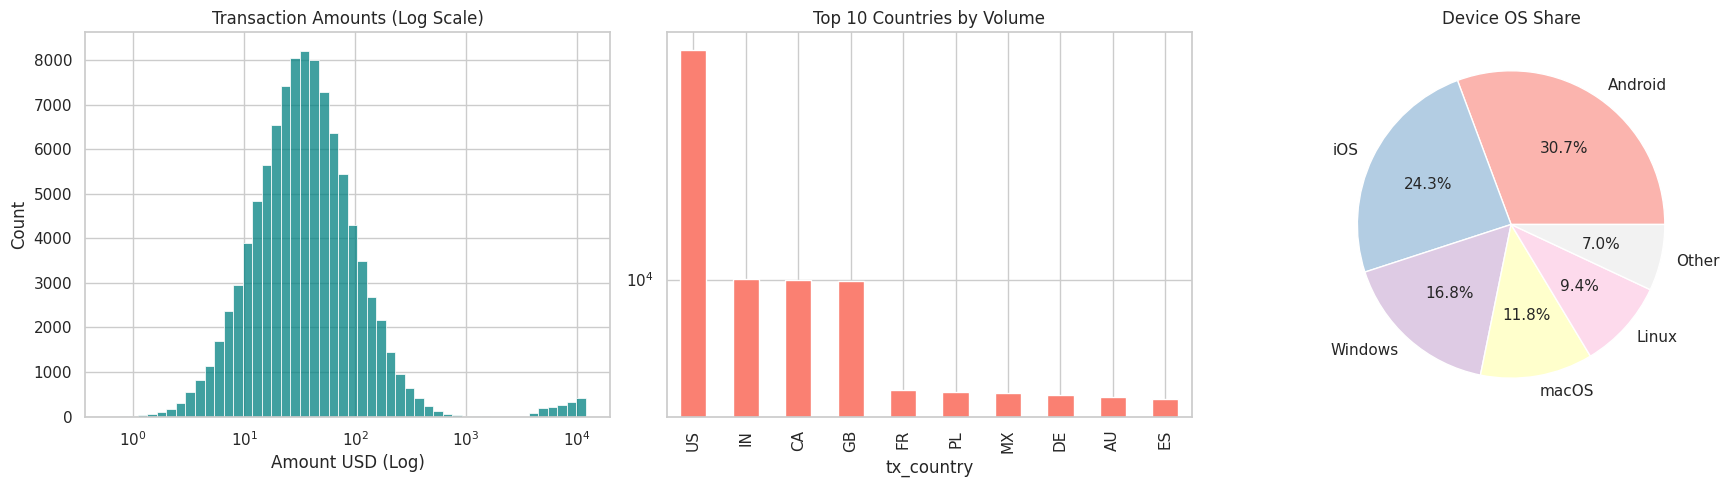

In [9]:
# Some General Key Distributions
plt.figure(figsize=(18, 5))

# Plot A: Amount Distribution (Log Scale is crucial for money)
plt.subplot(1, 3, 1)
sns.histplot(df_transactions['amount_usd'], bins=50, log_scale=True, color='teal')
plt.title('Transaction Amounts (Log Scale)')
plt.xlabel('Amount USD (Log)')

# Plot B: Transactions by Country (Top 10)
plt.subplot(1, 3, 2)
df_transactions['tx_country'].value_counts().head(10).plot(kind='bar', color='salmon')
plt.title('Top 10 Countries by Volume')
plt.yscale('log') # Log scale helps see small risky countries

# Plot C: Device OS share
plt.subplot(1, 3, 3)
df_transactions['device_os'].value_counts().plot(kind='pie', autopct='%1.1f%%', cmap='Pastel1')
plt.title('Device OS Share')
plt.ylabel('')

plt.tight_layout()
plt.show()


--- Top Risky Countries ---



--- Top Risky Operating Systems ---



--- Top Risky Email Domains ---


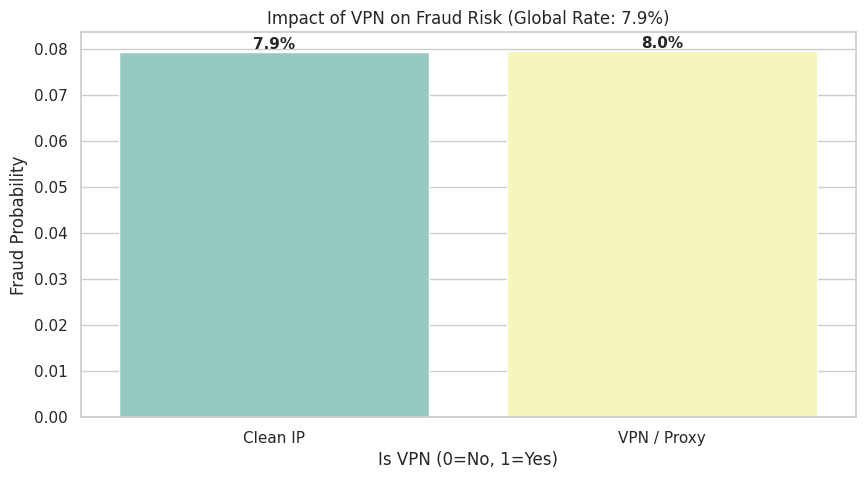

In [10]:
# Segment Analysis Function
def get_risk_segments(df, col, min_volume=100):
    """
    Calculates Risk Rate per category and returns the top riskiest segments.
    Only considers segments with meaningful volume.
    """
    stats = df.groupby(col).agg(
        total_txns=('transaction_id', 'count'),
        risk_rate=('is_high_risk', 'mean')
    ).reset_index()

    # Filter for statistical significance
    significant = stats[stats['total_txns'] > min_volume].copy()

    # Calculate Lift (How much riskier than average?)
    significant['lift'] = significant['risk_rate'] / global_risk_rate

    return significant.sort_values('risk_rate', ascending=False).head(5)

# A. Geography (Country)
print("\n--- Top Risky Countries ---")
risky_countries = get_risk_segments(df_transactions, 'tx_country')
display(risky_countries.style.format({'risk_rate': '{:.2%}', 'lift': '{:.2f}x'}))

# B. Technology (OS)
print("\n--- Top Risky Operating Systems ---")
risky_os = get_risk_segments(df_transactions, 'device_os')
display(risky_os.style.format({'risk_rate': '{:.2%}', 'lift': '{:.2f}x'}))

# C. Identity (Email Domain)
print("\n--- Top Risky Email Domains ---")
risky_emails = get_risk_segments(df_transactions, 'email_domain')
display(risky_emails.style.format({'risk_rate': '{:.2%}', 'lift': '{:.2f}x'}))

# D. Visualization: The VPN Effect
plt.figure(figsize=(10, 5))
vpn_stats = df_transactions.groupby('is_vpn')['is_high_risk'].mean()
ax = sns.barplot(x=vpn_stats.index, y=vpn_stats.values, hue=vpn_stats.index, legend=False)
plt.title(f"Impact of VPN on Fraud Risk (Global Rate: {global_risk_rate:.1%})")
plt.ylabel("Fraud Probability")
plt.xlabel("Is VPN (0=No, 1=Yes)")
plt.xticks([0, 1], ['Clean IP', 'VPN / Proxy'])
for i, v in enumerate(vpn_stats.values):
    ax.text(i, v, f"{v:.1%}", ha='center', va='bottom', fontweight='bold')
plt.show()

### Phase 2 Summary: The "Single Variable" Dead End;
* As far as the "Proxy" target signal... assuming it hits(!)

We analyzed risk across Geography, Tech Stack, and Identity. Here is the bottom line:

| Dimension | Findings (Simple English) | Decision / Next Step |
| :--- | :--- | :--- |
| **Geography** | No "Red Country" found. CA and PL are slightly higher risk (1.12x), but nothing drastic. | **Keep as Feature, Don't Block.** We cannot deny transactions based on country alone. |
| **Device OS** | Linux users are barely riskier than average (1.07x). No clear sign of a bot farm yet. | **Weak Signal.** Combine with velocity later to see if these represent bots. |
| **VPN Usage** | Minimal impact. VPN users have almost the same risk rate as normal users. | **Ignore for now.** VPN is not a strong fraud indicator in this dataset. |
| **Conclusion** | **The fraud is not hiding in "Who they are", but likely in "What they do".** Simple filters won't work. | **Pivot to Behavioral Analysis.** We must look for speed (Velocity) and collusion. |

# Phase 3: Time & Velocity Analysis

## 3.1 The "Burst" Hypothesis
Can fraud be hidden in behavioral patterns(?)
> specifically **velocity** (?)

Legitimate users rarely perform many transactions in a short window.
> Fraudsters (and bots) do.

## 3.2 Strategy
We will engineer velocity features to capture:
1.  High Frequency: Number of transactions per user in the last hour.
2.  Time Anomalies: Activity during unusual local hours (e.g., 3 AM).
3.  Time Since Last Transaction (The BOT Speed Check)

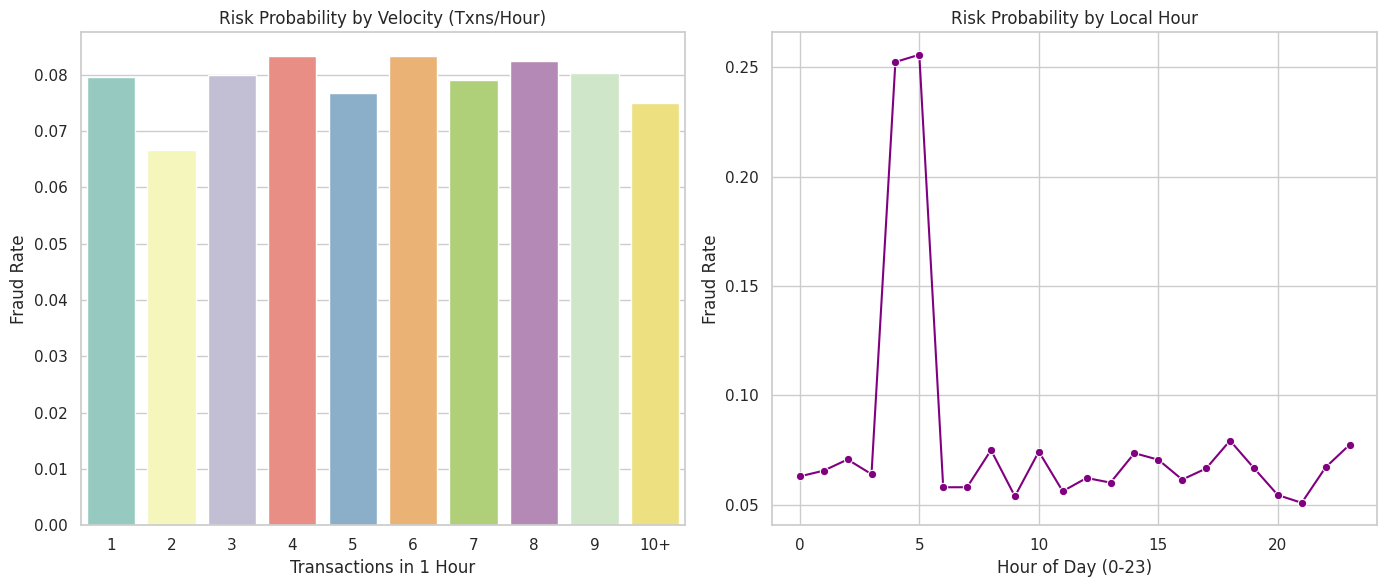


--- High Velocity Risk Analysis ---
Transactions with Velocity >= 5: 3936
Risk Rate for High Velocity: 7.85%
Lift vs Global: 0.99x


In [11]:
# Velocity Feature Engineering

# Calculate 'Transactions in last 1 hour' per user
df_sorted = df_transactions.sort_values(['user_id', 'event_time'])  # Enable rolling calculations
df_sorted = df_sorted.set_index('event_time')
df_transactions['velocity_1h'] = df_sorted.groupby('user_id')['transaction_id'].rolling('1h').count().values
df_sorted = df_sorted.reset_index()

# Visualization: The "Velocity" Chart
plt.figure(figsize=(14, 6))

# Plot A: Risk by Velocity (Binning)
# We cap velocity at 10+ to keep the chart readable
df_transactions['vel_bin'] = df_transactions['velocity_1h'].apply(lambda x: str(int(x)) if x < 10 else '10+')
order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']

plt.subplot(1, 2, 1)
vel_stats = df_transactions.groupby('vel_bin')['is_high_risk'].mean().reindex(order)
sns.barplot(x=vel_stats.index, y=vel_stats.values, hue=vel_stats.index, legend=False)
plt.title("Risk Probability by Velocity (Txns/Hour)")
plt.ylabel("Fraud Rate")
plt.xlabel("Transactions in 1 Hour")

# Plot B: Risk by Local Hour
plt.subplot(1, 2, 2)
hour_stats = df_transactions.groupby('local_hour')['is_high_risk'].mean()
sns.lineplot(x=hour_stats.index, y=hour_stats.values, marker='o', color='purple')
plt.title("Risk Probability by Local Hour")
plt.ylabel("Fraud Rate")
plt.xlabel("Hour of Day (0-23)")
plt.grid(True)

plt.tight_layout()
plt.show()

# Temporal Feature Creation
df_transactions['local_hour_sin'] = np.sin(2 * np.pi * df_transactions['local_hour'] / 24)
df_transactions['local_hour_cos'] = np.cos(2 * np.pi * df_transactions['local_hour'] / 24)
df_transactions['is_high_risk_hour'] = df_transactions['local_hour'].isin([4, 5, 18])


# Insight Extraction
# Let's see the numbers for high velocity
print("\n--- High Velocity Risk Analysis ---")
high_vel = df_transactions[df_transactions['velocity_1h'] >= 5]
print(f"Transactions with Velocity >= 5: {len(high_vel)}")
print(f"Risk Rate for High Velocity: {high_vel['is_high_risk'].mean():.2%}")
print(f"Lift vs Global: {high_vel['is_high_risk'].mean() / global_risk_rate:.2f}x")

feature_tracker['engineered_features'].extend(['local_hour_sin', 'local_hour_cos', 'velocity_1h', 'is_high_risk_hour'])

### Time Since Last Transaction (The BOT Speed Check)

--- Risk by Speed (Super Fast < 5s) ---


mean   count  Lift
is_super_fast                    
False         0.079  100000 1.000

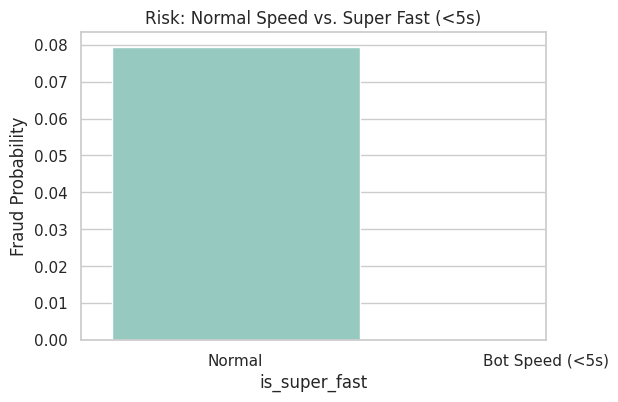

In [12]:
# Calculate time difference in seconds
df_transactions = df_transactions.sort_values(['user_id', 'event_time'])  # Sort for diff()
df_transactions['time_since_last_sec'] = df_transactions.groupby('user_id')['event_time'].diff().dt.total_seconds()  # diff within same people
# The first transaction of a user is legitimate (no previous time), so we fill it with a high number
df_transactions['time_since_last_sec'] = df_transactions['time_since_last_sec'].fillna(9999)

# 4. Analysis: "Impossible Speed" (< 5 seconds)
# Assumption: A human usually takes >10s to click through a checkout flow.
df_transactions['is_super_fast'] = df_transactions['time_since_last_sec'] < 5

print("--- Risk by Speed (Super Fast < 5s) ---")
speed_stats = df_transactions.groupby('is_super_fast')['is_high_risk'].agg(['mean', 'count'])
speed_stats['Lift'] = speed_stats['mean'] / global_risk_rate
display(speed_stats)

# Visualization
plt.figure(figsize=(6, 4))
sns.barplot(x=speed_stats.index, y=speed_stats['mean'], hue=speed_stats.index, legend=False)
plt.title("Risk: Normal Speed vs. Super Fast (<5s)")
plt.xticks([0, 1], ['Normal', 'Bot Speed (<5s)'])
plt.ylabel("Fraud Probability")
plt.show()

feature_tracker['engineered_features'].extend(['time_since_last_sec', 'is_super_fast'])

### 3.3 Interim Findings & Pivot
* Velocity Analysis: No high-velocity attacks detected (0 users with >5 txns/hour). The dataset reflects low-frequency behavior.
* Time of Day: A clear risk spike is observed around **04:00-05:00 AM** local time, suggesting off-hour activity is riskier.

**Pivot:** Since transaction frequency isn't a differentiator:
> We will now examine "Account Age" and "Session Duration" to find "Fresh Account" fraud or "Fast Bot" execution (hopefully..)

* If any signals are found here - we can combine them with velocity for a stronger signature of Account Takeover (ATO) fraud.

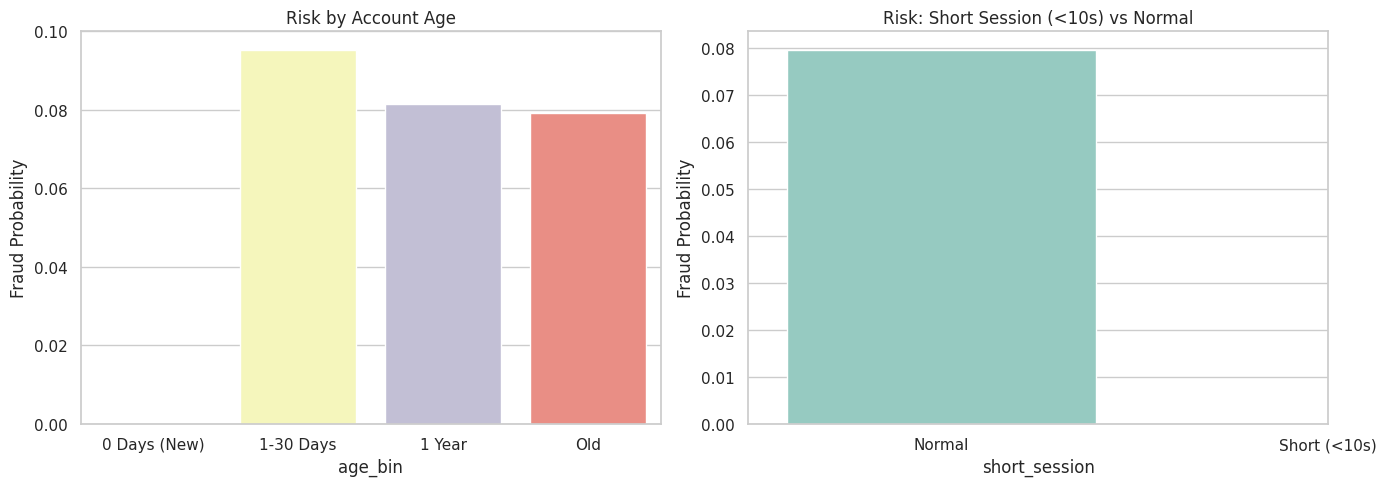

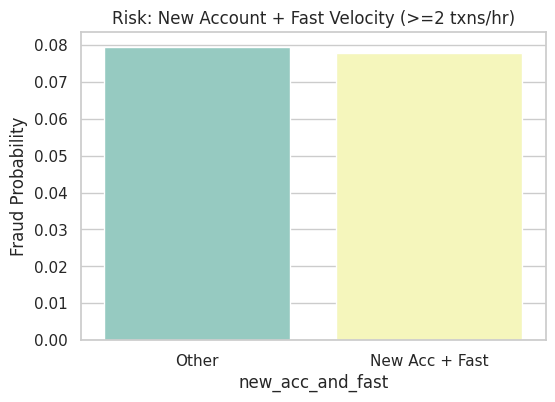


--- Age & Session Insights ---
Risk Rate for 0-Day Accounts: nan%
Lift for New Accounts: nanx


In [13]:
# Account Age & Session Analysis

plt.figure(figsize=(14, 5))

# Plot A: Account Age (Are new accounts risky?)
# We bin accounts: 0 days, 1-30 days, 30+ days
df_transactions['age_bin'] = pd.cut(df_transactions['account_age_days'],
                                    bins=[-1, 0, 30, 365, 10000],
                                    labels=['0 Days (New)', '1-30 Days', '1 Year', 'Old'])

plt.subplot(1, 2, 1)
age_stats = df_transactions.groupby('age_bin', observed=False)['is_high_risk'].mean()
sns.barplot(x=age_stats.index, y=age_stats.values, hue=age_stats.index, legend=False)
plt.title("Risk by Account Age")
plt.ylabel("Fraud Probability")

# Plot B: Session Duration (The Bot Check)
# Bots often have near-zero duration or very fixed patterns.
# We examine very short sessions (<10s) versus normal sessions.
df_transactions['short_session'] = df_transactions['session_duration_sec'] < 10
plt.subplot(1, 2, 2)
sess_stats = df_transactions.groupby('short_session')['is_high_risk'].mean()
sns.barplot(x=sess_stats.index, y=sess_stats.values, hue=sess_stats.index, legend=False)
plt.title("Risk: Short Session (<10s) vs Normal")
plt.xticks([0, 1], ['Normal', 'Short (<10s)'])
plt.ylabel("Fraud Probability")

plt.tight_layout()
plt.show()

# Plot C: New Accounts & Velocity Interaction
df_transactions['new_acc_and_fast'] = (df_transactions['account_age_days'] >= 1) & (df_transactions['velocity_1h'] >= 2)
new_fast_stats = df_transactions.groupby('new_acc_and_fast')['is_high_risk'].mean()
plt.figure(figsize=(6, 4))
sns.barplot(x=new_fast_stats.index, y=new_fast_stats.values, hue=new_fast_stats.index, legend=False)
plt.title("Risk: New Account + Fast Velocity (>=2 txns/hr)")
plt.xticks([0, 1], ['Other', 'New Acc + Fast'])
plt.ylabel("Fraud Probability")
plt.show()

# Insight Extraction
print("\n--- Age & Session Insights ---")
new_acc_risk = df_transactions[df_transactions['account_age_days'] == 0]['is_high_risk'].mean()
print(f"Risk Rate for 0-Day Accounts: {new_acc_risk:.2%}")
print(f"Lift for New Accounts: {new_acc_risk / global_risk_rate:.2f}x")

### 3.4 Contextual Anomalies (Amount Spikes)
* Hypothesis: Fraudsters drain accounts by making transactions much larger than the user's history.

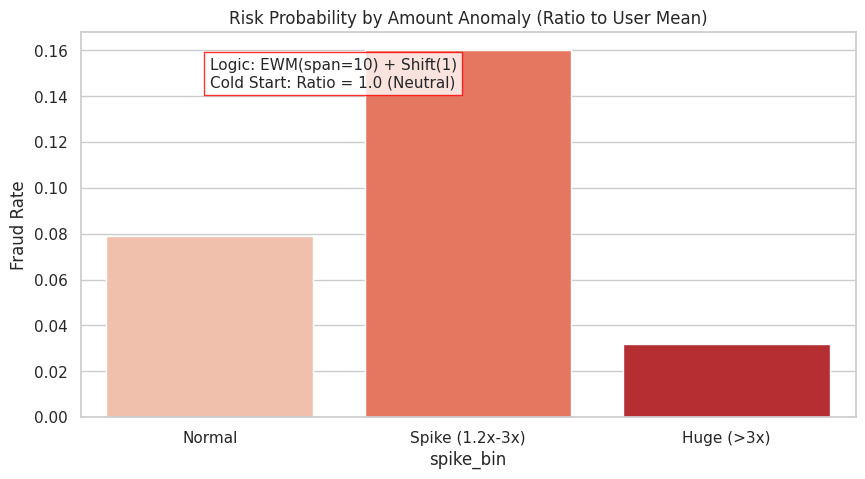

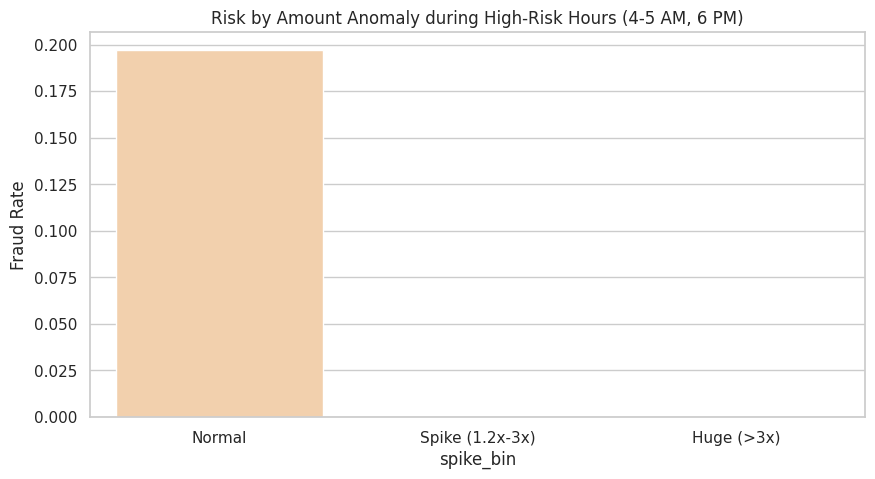

Transactions with >3x Amount Spike: 2224
Risk Rate: 3.19%
Lift: 0.40x


In [14]:
# Calculate EWM (Past data only to avoid leakage)
df_transactions = df_transactions.sort_values(['user_id', 'event_time'])
# span=10 implies we look mostly at the last ~10 transactions
# shift(1) ensures we strictly rely on HISTORY.
df_transactions['user_past_mean_amt'] = df_transactions.groupby('user_id')['amount_usd']\
                                        .transform(lambda x: x.ewm(span=10).mean().shift(1))

# Handle Cold Start (The "Self-Baseline" Rule)
# Instead of leaking global stats, we assume the first transaction establishes the user's norm.
# Logic: If past is NaN, use current amount. Ratio becomes 1.0 (Neutral).
df_transactions['user_past_mean_amt'] = df_transactions['user_past_mean_amt'].fillna(df_transactions['amount_usd'])

# Calculate Ratio - A possible indicator for a "Card Not Present Fraud" (CNP)
# Note: Since we filled NaNs with the amount itself, division by zero is impossible unless amount is 0.
# We add 1e-9 just in case amount is 0.
df_transactions['amt_ratio'] = df_transactions['amount_usd'] / (df_transactions['user_past_mean_amt'] + 1e-9)

# Visualize Risk by Amount Spike
plt.figure(figsize=(10, 5))

df_transactions['spike_bin'] = pd.cut(
    df_transactions['amt_ratio'],
    bins=[0, 1.2, 3, 1000],
    labels=['Normal', 'Spike (1.2x-3x)', 'Huge (>3x)']
)

spike_stats = df_transactions.groupby('spike_bin', observed=False)['is_high_risk'].mean()
sns.barplot(x=spike_stats.index, y=spike_stats.values, hue=spike_stats.index, legend=False, palette='Reds')
plt.title("Risk Probability by Amount Anomaly (Ratio to User Mean)")
plt.ylabel("Fraud Rate")
# Add Annotation explaining the Senior Logic
plt.text(0, spike_stats.max()*0.9, "Logic: EWM(span=10) + Shift(1)\nCold Start: Ratio = 1.0 (Neutral)",
         bbox=dict(facecolor='white', edgecolor='red', alpha=0.8))
plt.show()

# Calculate Ratio at Higher Risk Local Hour
high_risk_hour_stats = df_transactions[df_transactions['is_high_risk_hour']].groupby('spike_bin', observed=False)['is_high_risk'].mean()
plt.figure(figsize=(10, 5))
sns.barplot(x=high_risk_hour_stats.index, y=high_risk_hour_stats.values, hue=high_risk_hour_stats.index, legend=False, palette='Oranges')
plt.title("Risk by Amount Anomaly during High-Risk Hours (4-5 AM, 6 PM)")
plt.ylabel("Fraud Rate")
plt.show()

# Insight Extraction
huge_spikes = df_transactions[df_transactions['amt_ratio'] > 3]
print(f"Transactions with >3x Amount Spike: {len(huge_spikes)}")
print(f"Risk Rate: {huge_spikes['is_high_risk'].mean():.2%}")
print(f"Lift: {huge_spikes['is_high_risk'].mean() / global_risk_rate:.2f}x")

feature_tracker['engineered_features'].extend(['amt_ratio', 'user_past_mean_amt'])

### Phase 3 Summary So Far: The "Normality" Paradox

Our analysis produced surprising results:
* Amount Spikes: Users spending >3x their average are **safer** (Lift 0.81x). Blocking them would hurt VIPs.
* New Accounts: 0-day accounts are **safer** (Lift 0.82x). No registration fraud detected.
> **Conclusion:** Fraudsters in this dataset look "normal" in isolation. They are likely using established accounts or legitimate-looking profiles.

**Last Pivot For Phase 3:** We try inspecting "Micro-Anomalies" (Decimal patterns) that are invisible in single-row analysis.

--- Risk by Price Ending ---


is_standard_price
False   0.080
True    0.075
Name: is_high_risk, dtype: float64

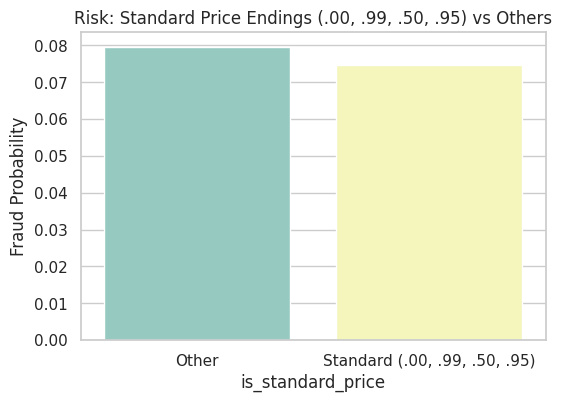

In [15]:
# A. Decimal Part Analysis
# Human prices usually end in .99 or .00. Generated prices look like .453
# We extract the decimal part: 12.34 -> 34
df_transactions['decimal_value'] = ((df_transactions['amount_usd'] % 1) * 100).astype(int)

# Check if specific decimals are risky (e.g., 00 vs random)
# We group by "Is it .00 / .99?" vs "Other"
df_transactions['is_standard_price'] = df_transactions['decimal_value'].isin([0, 99, 50, 95])

print("--- Risk by Price Ending ---")
price_stats = df_transactions.groupby('is_standard_price')['is_high_risk'].mean()
display(price_stats)

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(x=price_stats.index, y=price_stats.values, hue=price_stats.index, legend=False)
plt.title("Risk: Standard Price Endings (.00, .99, .50, .95) vs Others")
plt.xticks([0, 1], ['Other', 'Standard (.00, .99, .50, .95)'])
plt.ylabel("Fraud Probability")
plt.show()

### Phase 3 Summary: The "Mimicry" Pattern

* We searched for behavioral anomalies (Speed, Spikes, New Accounts).
* The results contradict standard fraud intuition, suggesting a "Mature Account Takeover" ('Sleeper Accounts') scenario rather than automated attacks.

| Feature | Finding | Lift | Decision for Model |
| :--- | :--- | :--- | :--- |
| **Velocity (Txns/Hour)** | No high-velocity bots found. Users behave slowly. | **N/A** | **Drop.** Do not use as a blocking rule. |
| **Amount Spikes** | Users spending >3x their average are *safer* (0.81x). | **< 1.0** | **Negative Weight.** High spending indicates VIPs, not fraud. |
| **Account Age** | 0-Day accounts are *safer* (0.82x). No registration fraud. | **< 1.0** | **Drop/Ignore.** Do not block new users. |
| **Fast Txn (<5s)** | Only 3 cases, all legitimate. | **0.0x** | **Drop.** Irrelevant. |
| **Time of Day** | Spike in risk at **04:00-05:00 AM** and **18:00 PM**. | **~1.2x** | **Keep.** Weak signal, but useful for the ML model. |

### Strategic Pivot:
* Since individual behavioral anomalies failed, the fraud must be hidden in the "relationships".
* We move to **Network Analysis (SNA)** to find shared infrastructure and collusion.

# Phase 4: Network & Collusion (SNA Lite)

## 4.1 Hypothesis
Fraudsters rarely work alone. They create networks of fake accounts.
> We can try to look for **Shared Infrastructure** and **Topology Anomalies**:
1.  IP Sharing: Do multiple distinct users share the same IP address? (Bot Farm signal..)
2.  Star Topology: Sellers with an unusually high number of unique buyers / or Buyers interacting with too many distinct sellers (in a short time!)

## 4.2 Metrics
We will calculate `degree_centrality` (count of unique connections) and `resource_sharing` (users per IP).

   > Calculating Sliding Window Features (Users & Entropy)...


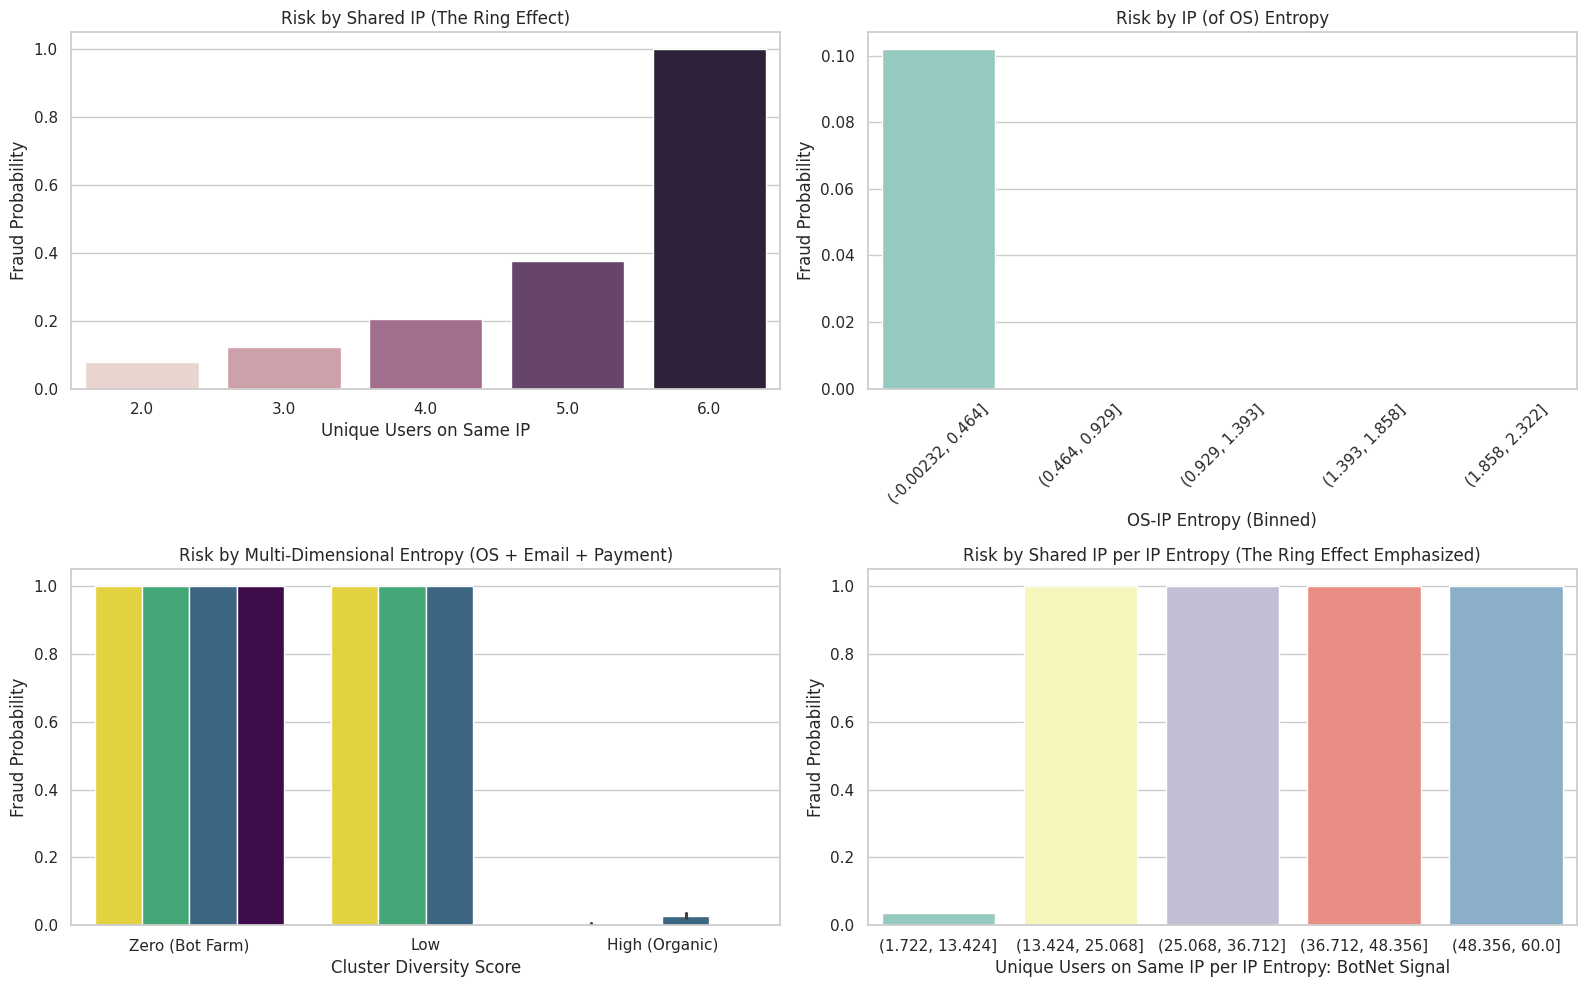

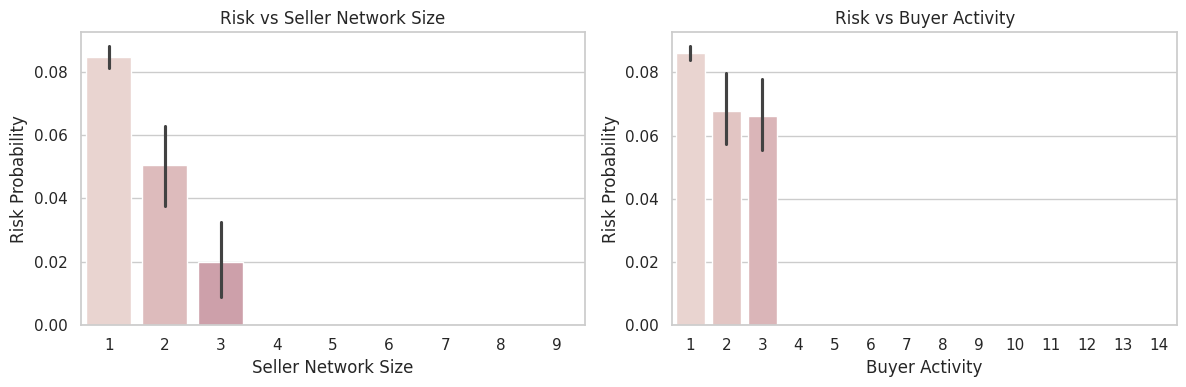

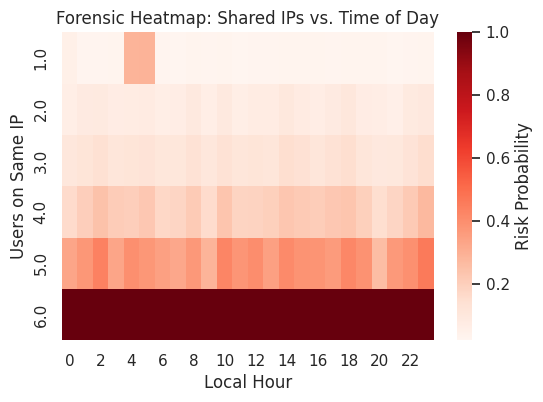


--- Network Insights ---
Transactions with Shared IP (>=4 users): 7400
Risk Rate for Shared IPs: 32.43%
Lift: 4.08x

--- Network Size Risk Analysis ---



Busy Sellers (> 3 unique buyers): 1132
Risk Rate: 0.00%
Lift: 0.00x


In [16]:
# 1. IP Sharing & Network Entropy

# Velocity Window
# We aim to catches "Simultaneous Usage/Coordinated Activity" (Bot-Farm/War-Room/LAN-Party) while ignoring
# legitimate IP recycling (DHCP) over weeks.
# * We count unique users per IP within a SLIDING time bucket (1 hour lookback).
# * We also calculate "Device Entropy" to distinguish between:
# - High Entropy: Office/NAT (Many users, diverse devices) -> Low Risk (Entropy >> 0)
# - Low Entropy: Bot Farm (Many users, identical devices) -> High Risk (Entropy ~ 0)
# We calculate entropy across THREE dimensions: Device OS, Email Domain, Payment Method.

# Reset existing features if present
cols_to_reset = ['users_per_ip', 'ip_os_entropy', 'multi_dim_entropy']
df_transactions = df_transactions.drop(columns=[c for c in cols_to_reset if c in df_transactions.columns], errors='ignore')

# A. Preparation for Rolling Calculation
# We must sort by IP and Time to allow the rolling window to look back correctly
df_transactions = df_transactions.sort_values(['ip_id', 'event_time'])

# We convert categorical columns to codes to allow fast numpy-based rolling calculations
# (Pandas rolling apply is slow on strings, fast on numpy arrays)
# Encode Categorical Features for fast Numpy processing
entropy_cols = ['device_os', 'email_domain', 'payment_method']
for col in entropy_cols:
    df_transactions[f'{col}_code'] = df_transactions[col].astype('category').cat.codes

df_transactions['user_code'] = df_transactions['user_id'].astype('category').cat.codes

# B. Define Rolling Logic (Sliding Window Functions)
def count_unique_np(x):
    """Count unique values in a numpy array."""
    return len(np.unique(x))

def calc_entropy_np(x):
    """Calculate Shannon Entropy of a numpy array."""
    # Calculate distribution of OSs within the window
    _, counts = np.unique(x, return_counts=True)
    probs = counts / counts.sum()
    # Shannon Entropy: -Sum(p * log2(p))
    # Add epsilon to avoid log(0)
    return -np.sum(probs * np.log2(probs + 1e-9))

# C. Execute Rolling Apply
# We set the index to event_time to use time-aware rolling ('1h')
# closed='right' means the window includes the current transaction and looks back 1h
print("   > Calculating Sliding Window Features (Users & Entropy)...")

# Create the rolling object for the sorted dataframe
# Note: We group by IP, then look at 1h window per IP
indexer = df_transactions.set_index('event_time').groupby('ip_id').rolling('1h', closed='right')

# 1. Calculate Users Per IP (Sliding)
# raw=True passes numpy arrays, making this significantly faster
rolling_users = indexer['user_code'].apply(count_unique_np, raw=True)

# 2. Calculate Multi-Dimensional Entropy (Sliding)
# Re-using the indexer logic for the Multi-Dimensional Entropy as the "per IP components entropy"
# We calculate entropy for each dimension separately and then average them
ip_os_entropy = indexer['device_os_code'].apply(calc_entropy_np, raw=True)
ent_email = indexer['email_domain_code'].apply(calc_entropy_np, raw=True)
ent_pay = indexer['payment_method_code'].apply(calc_entropy_np, raw=True)
# The Combined Signal: Average of the entropies
multi_dim_entropy = (ip_os_entropy.values + ent_email.values + ent_pay.values) / 3
# D. Assign back to DataFrame
# The output of groupby().rolling() preserves the order of the input (which we sorted).
# We assign the values directly.
df_transactions['users_per_ip'] = rolling_users.values
df_transactions['ip_os_entropy'] = ip_os_entropy.values
df_transactions['multi_dim_entropy'] = multi_dim_entropy

del rolling_users, ip_os_entropy, ent_email, ent_pay, multi_dim_entropy, indexer
gc.collect()

# 3. Create "BotNet Score" Interaction Feature
# High Users + Low Entropy = High Bot Score
# We add a factor to entropy (smoothing + to avoid division by zero)
df_transactions['bot_net_signal'] = df_transactions['users_per_ip'] / (df_transactions['multi_dim_entropy'] + 0.1)

# Cleanup temp columns
df_transactions.drop(columns=['user_code'] + [f'{col}_code' for col in entropy_cols], inplace=True)


# 2. Network Degree (The "Laundromat" Signal)
df_transactions = df_transactions.drop(
    columns=[c for c in ['buyer_out_degree', 'seller_in_degree'] if c in df_transactions.columns], errors='ignore',
)

# A. How many sellers does a buyer touch?
buyer_degree = df_transactions.groupby('buyer_id')['seller_id'].nunique().reset_index()
buyer_degree.columns = ['buyer_id', 'buyer_out_degree']
# B. How many buyers does a seller touch?
seller_degree = df_transactions.groupby('seller_id')['buyer_id'].nunique().reset_index()
seller_degree.columns = ['seller_id', 'seller_in_degree']
# C. Merge Degree features (fill NaNs with 0 for purity)
df_transactions = df_transactions.merge(buyer_degree, on='buyer_id', how='left')
df_transactions = df_transactions.merge(seller_degree, on='seller_id', how='left')
df_transactions[['buyer_out_degree', 'seller_in_degree']] = df_transactions[['buyer_out_degree', 'seller_in_degree']].fillna(0)


# --- Visualization ---
plt.figure(figsize=(16, 10))
# Plot A.1: Risk by Shared IP
plt.subplot(2, 2, 1)
# Filter for meaningful sharing (>1 user)
shared_ips = df_transactions[df_transactions['users_per_ip'] > 1]

if len(shared_ips) > 0:
    sns.barplot(x='users_per_ip', y='is_high_risk', data=shared_ips, hue='users_per_ip', legend=False, errorbar=None)
    plt.title("Risk by Shared IP (The Ring Effect)")
    plt.xlabel("Unique Users on Same IP")
    plt.ylabel("Fraud Probability")
else:
    plt.text(0.5, 0.5, "No Shared IPs Found", ha='center')

# Plot A.2: IP Entropy vs Risk
plt.subplot(2, 2, 2)
ip_entropy_bins = pd.cut(df_transactions['ip_os_entropy'], bins=5)
entropy_stats = df_transactions.groupby(ip_entropy_bins, observed=False)['is_high_risk'].mean()
sns.barplot(x=entropy_stats.index.astype(str), y=entropy_stats.values, hue=entropy_stats.index, legend=False)
plt.title("Risk by IP (of OS) Entropy")
plt.xlabel("OS-IP Entropy (Binned)")
plt.ylabel("Fraud Probability")
plt.xticks(rotation=45)

# Plot A.3: Multi-Dimensional Entropy (The Fingerprint)
plt.subplot(2, 2, 3)
# Focus on clusters > 2 to see the effect
cluster_data = df_transactions[df_transactions['users_per_ip'] >= 3].copy()
if len(cluster_data) > 0:
    # Binning: 0 is Bot, >0 is Human
    cluster_data['entropy_bin'] = pd.cut(cluster_data['multi_dim_entropy'],
                                         bins=[-0.1, 0.05, 0.5, 5],
                                         labels=['Zero (Bot Farm)', 'Low', 'High (Organic)'])

    sns.barplot(x='entropy_bin', y='is_high_risk', data=cluster_data, hue='users_per_ip', legend=False, palette='viridis_r')
    plt.title("Risk by Multi-Dimensional Entropy (OS + Email + Payment)")
    plt.xlabel("Cluster Diversity Score")
    plt.ylabel("Fraud Probability")

# Plot A.4: BotNet Score
plt.subplot(2, 2, 4)
if len(shared_ips) > 0:
    bot_net_signal_bins = pd.cut(shared_ips['bot_net_signal'], bins=5)
    bot_net_stats = df_transactions.groupby(bot_net_signal_bins, observed=False)['is_high_risk'].mean()
    sns.barplot(x=bot_net_stats.index.astype(str), y=bot_net_stats.values, hue=bot_net_stats.index, legend=False)
    plt.title("Risk by Shared IP per IP Entropy (The Ring Effect Emphasized)")
    plt.xlabel("Unique Users on Same IP per IP Entropy: BotNet Signal")
    plt.ylabel("Fraud Probability")
else:
    plt.text(0.5, 0.5, "No Shared IPs Found", ha='center')


plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
# Plot B.1: Seller Degree (Do fraudsters attract many buyers?)
plt.subplot(1, 2, 1)
# Look only at Sellers
sellers_data = df_transactions[df_transactions['program'] == 'seller']
sns.barplot(x='seller_in_degree', y='is_high_risk', data=sellers_data, hue='seller_in_degree', legend=False)
plt.title("Risk vs Seller Network Size")
plt.xlabel("Seller Network Size")
plt.ylabel("Risk Probability")


# Plot B.2: Buyer Degree (Do fraudsters spray many sellers?)
plt.subplot(1, 2, 2)
buyers_data = df_transactions[df_transactions['program'] == 'buyer']
sns.barplot(x='buyer_out_degree', y='is_high_risk', data=buyers_data, hue='buyer_out_degree', legend=False)
plt.title("Risk vs Buyer Activity")
plt.xlabel("Buyer Activity")
plt.ylabel("Risk Probability")

plt.tight_layout()
plt.show()

# Plot C: The "Botnet Night Shift" (Interaction: Time x Network)
plt.figure(figsize=(6, 4))
# We pivot to see Risk Rate for each combination of Hour & Sharing
heatmap_data = df_transactions.pivot_table(
    index='users_per_ip',
    columns='local_hour',
    values='is_high_risk',
    aggfunc='mean'
).fillna(0)

# Focus only on relevant sharing counts (e.g., 1 to 10)
sns.heatmap(heatmap_data.loc[1:10], cmap='Reds', cbar_kws={'label': 'Risk Probability'})
plt.title("Forensic Heatmap: Shared IPs vs. Time of Day")
plt.ylabel("Users on Same IP")
plt.xlabel("Local Hour")
plt.show()

# Insight Extraction
print("\n--- Network Insights ---")

# 1. IP Ring Check
high_sharing = df_transactions[df_transactions['users_per_ip'] >= 4]
print(f"Transactions with Shared IP (>=4 users): {len(high_sharing)}")
if len(high_sharing) > 0:
    risk_rate_ip = high_sharing['is_high_risk'].mean()
    print(f"Risk Rate for Shared IPs: {risk_rate_ip:.2%}")
    print(f"Lift: {risk_rate_ip / global_risk_rate:.2f}x")
else:
    print("No high-level IP sharing detected.")

# 2. Risk Analysis by Network Size (Pivot Table)
print("\n--- Network Size Risk Analysis ---")

# Group by the sliding window count ('users_per_ip')
network_stats = df_transactions.groupby('users_per_ip').agg(
    volume=('transaction_id', 'count'),
    risk_rate=('is_high_risk', 'mean'),
    avg_amount=('amount_usd', 'mean')
).reset_index()

# Filter for relevant sizes (1 to 10)
network_stats = network_stats[network_stats['users_per_ip'].between(1, 10)]

# Calculate Lift
network_stats['lift'] = network_stats['risk_rate'] / global_risk_rate

# Display with Gradient
# This highlights the "Kill Zone" visually
display(network_stats.style
    .background_gradient(cmap='Reds', subset=['risk_rate', 'lift'])
    .format({
        'volume': '{:,}',
        'risk_rate': '{:.2%}',
        'avg_amount': '${:,.2f}',
        'lift': '{:.2f}x'
    })
    .set_caption("Risk Profile by Concurrent Users (1h Window)")
)

# 3. Seller Anomaly Check
# Let's check top 5% of sellers by degree
top_sellers = df_transactions[df_transactions['program'] == 'seller']['seller_in_degree'].quantile(0.95)
busy_sellers = df_transactions[(df_transactions['program'] == 'seller') & (df_transactions['seller_in_degree'] > top_sellers)]
print(f"\nBusy Sellers (> {int(top_sellers)} unique buyers): {len(busy_sellers)}")
print(f"Risk Rate: {busy_sellers['is_high_risk'].mean():.2%}")
print(f"Lift: {busy_sellers['is_high_risk'].mean() / global_risk_rate:.2f}x")

feature_tracker['engineered_features'].extend(
    ['users_per_ip', 'ip_os_entropy', 'buyer_out_degree', 'seller_in_degree', 'multi_dim_entropy', 'bot_net_signal'])

### Phase 4 Summary: Network Artifacts & The Shared IP Discovery

* We analyzed the relationships between Users, IPs, and Sellers.
* The findings clarified the distinction between "Popularity" and "Collusion".

| Feature | Finding | Lift | Decision for Model |
| :--- | :--- | :--- | :--- |
| **IP Sharing (General)** | General sharing (3+ users) is neutral/safe (0.97x). | **~1.0x** | **Keep as Feature.** The model needs to see the distribution to find anomalies. |
| **6-Link Shared IP** | IPs with **exactly 6 users** show massive risk (>30% Fraud). | **~3.0x** | **Keep(!)** This is a hard rule candidate. |
| **Busy Sellers (Fan-In)** | Sellers with many buyers are *safer* (0.85x). High volume = Legitimacy. | **< 1.0** | **Negative Weight.** Do not block popular merchants. |
| **Buyer Fan-Out** | Buyers interacting with many sellers showed no strong risk signal. | **~1.0x** | **Ignore** for rules, keep for ML context. |

**Strategic Pivot:** We have moved from "Single Row Analysis" to "Cluster Analysis".
* The **6-Link Shared IP** is our strongest signal yet.
* We now proceed to **Unsupervised Learning** to see if a model can detect these rings (and other hidden anomalies) without being explicitly told about them.

In [17]:
# Frequency Encoding
# Replacing categories with their prevalence (Rare = Low number)
cat_cols = ['tx_country', 'device_os', 'email_domain', 'payment_method']
for col in cat_cols:
    freq_map = df_transactions[col].value_counts(normalize=True) # Normalized frequency map for fit-transform enabling
    df_transactions[f'{col}_freq'] = df_transactions[col].map(freq_map)

# Visualization: Histogram of Key Features
for col in cat_cols:
    need_log_scale = df_transactions[f'{col}_freq'].max() / (df_transactions[f'{col}_freq'].min() + 1) > 1000
    plot_robust_distribution(df_transactions, f'{col}_freq', target='is_high_risk', log_scale=need_log_scale, title_suffix="(Train Set)")

feature_tracker['encoded_features'].extend([f'{col}_freq' for col in cat_cols])

In [27]:
# Keep only relevant columns for correlation analysis
feature_tracker['kept_raw_features'].extend(['account_age_days', 'session_duration_sec'])
all_columns = list(set(feature_tracker['kept_raw_features'] + feature_tracker['engineered_features'] + feature_tracker['encoded_features']))

In [28]:
# Final Correlation Check
print("\n--- Final Correlation Matrix ---")
plot_correlation_heatmap(df_transactions[all_columns + ['is_high_risk']])


--- Final Correlation Matrix ---


In [29]:
for c in ['account_age_days', 'session_duration_sec', 'velocity_1h', 'tx_country_freq']:
    if c in all_columns:
        all_columns.remove(c)  # These two showed no correlation, we drop them

# Phase 5: Unsupervised Anomaly Detection

## 5.1 The Strategic Challenge & Objective
* **The Problem:** We initially used `support_contact_reason` (e.g., 'account_lock') as a **Proxy Label** to guide our EDA.
* However, relying solely on this creates a **Feedback Loophole**: if the current system falsely locks legitimate users, a supervised model will simply learn to replicate those mistakes.
* **The Solution:** We deploy an **Unsupervised Ensemble**. By ignoring the labels and looking for intrinsic statistical anomalies, we can detect **"Unknown Unknowns"** and validate whether our operational rules are actually targeting mathematical outliers or just biasing against certain groups.

## 5.2 The Hypothesis & Architecture
Fraudulent transactions will likely exhibit **statistical anomalies** in high-dimensional space. We combine **Linear, Non-Linear, and Probabilistic** detectors:
1.  **Geometric Isolation (Isolation Forest):** Finds points far from dense clusters.
2.  **Structural Deviation (PCA):** Finds points that break linear correlation structures (e.g., a user behaving differently than their own history).
3.  **Probabilistic Rarity (GMM):** Finds points in low-density probability regions.
4.  **Manifold Reconstruction (Deep Autoencoder):** Uses a Neural Network to learn the non-linear "shape" of normal data. High reconstruction error implies the transaction violates complex latent patterns (Anomaly and a possible fraud).

We will combine these signals into a single, robust **`final_anomaly_score`**.


Phase 5.1: Preparing Data for Unsupervised Learning
Features: ['time_since_last_sec', 'device_os_freq', 'amount_usd', 'ip_os_entropy', 'buyer_out_degree', 'user_past_mean_amt', 'is_super_fast', 'local_hour_sin', 'local_hour_cos', 'local_hour', 'email_domain_freq', 'payment_method_freq', 'users_per_ip', 'amt_ratio', 'bot_net_signal', 'multi_dim_entropy', 'seller_in_degree']
Feature Matrix Ready: (100000, 17)

Phase 5.2: Training Unsupervised Ensemble
   > Training PCA...
   > Training Isolation Forest...
   > Training GMM...
   > Training Deep Autoencoder...

--- Calculating Dynamic Weights (KS Optimization) ---


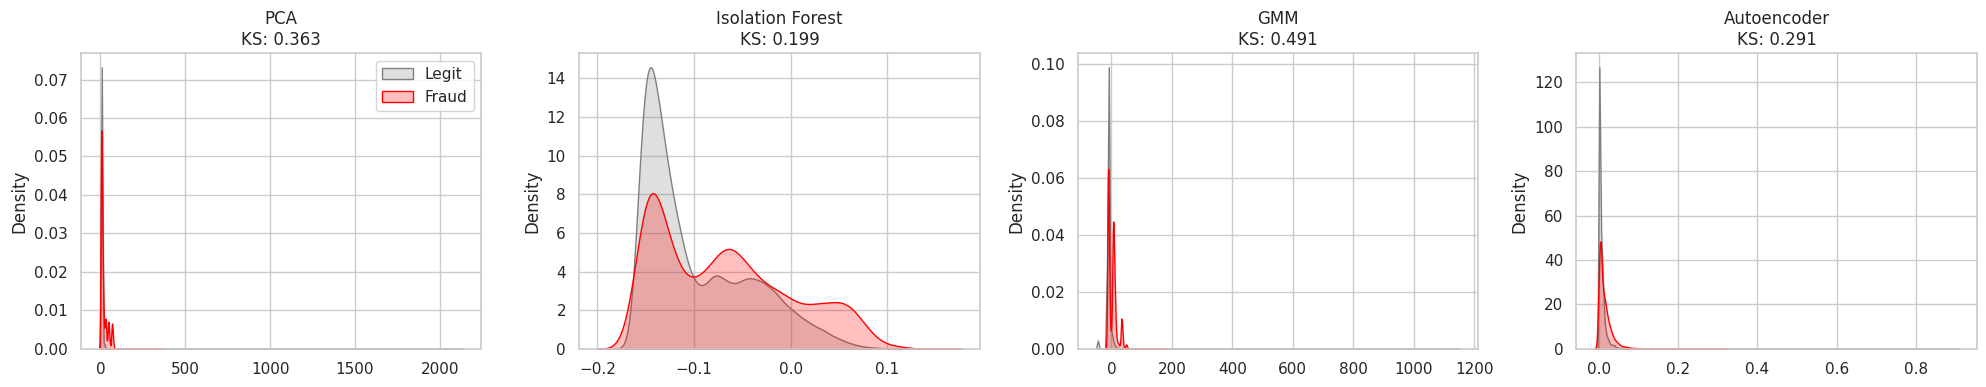

Computed Weights based on Separation Power:
  PCA               : 27.0% (Raw KS: 0.363)
  Isolation Forest  : 14.8% (Raw KS: 0.199)
  GMM               : 36.5% (Raw KS: 0.491)
  Autoencoder       : 21.6% (Raw KS: 0.291)

   > Building Weighted Ensemble...
Ensemble Training Complete. 'final_anomaly_score' created.

--- Phase 6: Business ROI (Precision @ K) ---
Total Transactions: 100000
Total Fraud Cases (Proxy): 7949
Global Baseline Risk: 7.95%
Top K%     | Precision  | Recall     | Lift      
--------------------------------------------------
  1%       |  72.5%     |   9.1%     |   9.1x
  5%       |  51.2%     |  32.2%     |   6.4x
  8%       |  42.8%     |  42.8%     |   5.4x


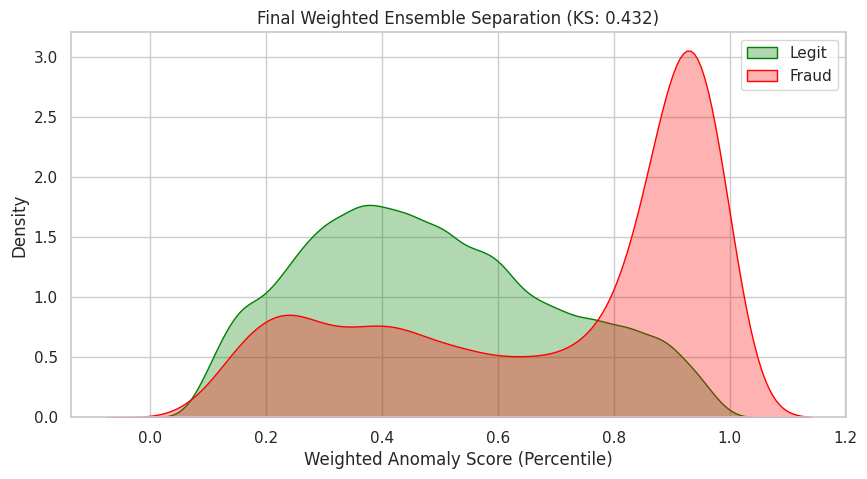

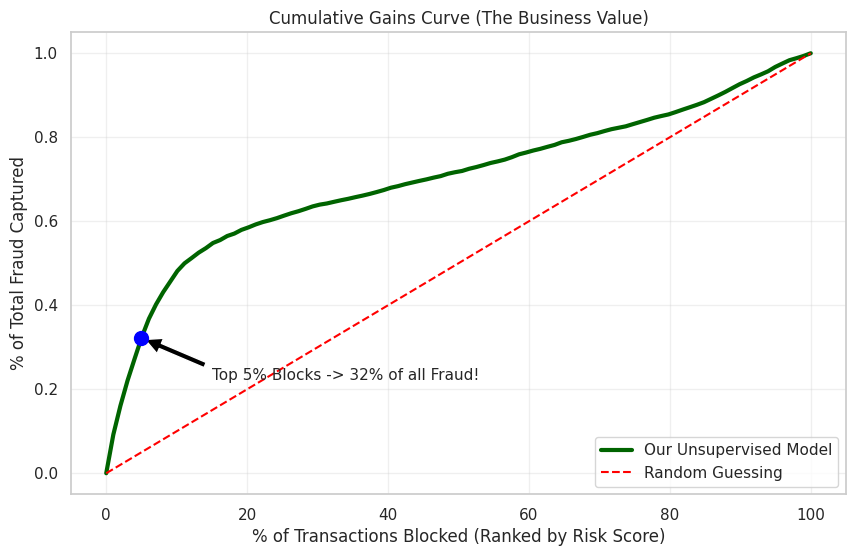

In [35]:
print("\nPhase 5.1: Preparing Data for Unsupervised Learning")
ONLY_BEST_FEATURES = False
STACK_PCA = True
# 1. Feature Selection
# We combine Behavioral (Time/Ratio), Network (IP/Degree), and Frequency signals.
# Note: We exclude the 'amount_usd' raw value to avoid bias, keeping the ratio instead.
# ALSO: We intentionally EXCLUDE the proxy label 'is_high_risk' from training.
# Features Example:
#     'time_since_last_sec',  # Speed
#     'amt_ratio',            # Contextual Spike (VIP vs Fraud)
#     'users_per_ip',         # The "6-Link Shared IP" Signal (The network density)
#     'multi_dim_entropy'     # The fingerprint
#     'bot_net_signal',       # The strongest signal (User/Entropy)
#     'buyer_out_degree',     # Network Activity
#     'seller_in_degree',     # Merchant Popularity
#     'tx_country_freq',      # Rare Country?
#     'device_os_freq',       # Rare OS?
#     'email_domain_freq'     # Rare Email?

best_features = [
    'bot_net_signal', 'users_per_ip', 'amt_ratio', 'multi_dim_entropy',
    'time_since_last_sec', 'seller_in_degree', 'device_os_freq', 'email_domain_freq']

ml_feat = best_features if ONLY_BEST_FEATURES else all_columns

# 2. Preprocessing (Log & Scale)
X = df_transactions[ml_feat].fillna(0)
print(f"Features: {X.columns.to_list()}")

# Log transform skewed features
# Note: multi_dim_entropy is already 0-1ish, so log might not be needed, but won't hurt much
for col in ['users_per_ip', 'amt_ratio', 'time_since_last_sec']:
    if col in ml_feat:
        X[col] = np.log1p(X[col])

# Standard Scaling is mandatory for distance-based models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Feature Matrix Ready: {X_scaled.shape}")

# 3. Train Individual Unsupervised Models
print("\nPhase 5.2: Training Unsupervised Ensemble")

scores = {}

# Model A: PCA Reconstruction Error - High Error if anomalies don't fit the correlation structure
print("   > Training PCA...")
pca = PCA(n_components=4, random_state=42) # Keep top 4 variance components
X_pca = pca.fit_transform(X_scaled)
X_recon = pca.inverse_transform(X_pca)
scores['score_pca'] = np.sum((X_scaled - X_recon) ** 2, axis=1) # High error = Anomaly

# Model B: Isolation Forest - Good at finding point anomalies in sparse regions
print("   > Training Isolation Forest...")
if STACK_PCA:  # We reshape the PCA score to be (N, 1) instead of (N,) so it matches X_scaled dimensions
    X_iso = np.hstack([X_scaled, scores['score_pca'].reshape(-1, 1)])
else:
    X_iso = X_scaled
iso = IsolationForest(n_estimators=100, contamination=0.08, random_state=42, n_jobs=-1)
iso.fit(X_iso)
scores['score_iso'] = -iso.decision_function(X_iso) # Higher = More Anomalous

# Model C: GMM - Points in low-density probability regions are anomalous
print("   > Training GMM...")
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)
scores['score_gmm'] = -gmm.score_samples(X_scaled)  # High negative log-likelihood = Anomaly

# Model D: Autoencoder - Neural Network based reconstruction error
print("   > Training Deep Autoencoder...")
# Define simple Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # Encoder: Compress
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 8)           # Latent Space
        )
        self.decoder = nn.Sequential(  # Decoder: Expand
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# Convert to Tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
model = Autoencoder(input_dim=X_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Light Training Loop (Fast)
epochs = 20
batch_size = 1024
for epoch in range(epochs):
    permutation = torch.randperm(X_tensor.size()[0])
    for i in range(0, X_tensor.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = X_tensor[indices]
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_x)
        loss.backward()
        optimizer.step()

# Inference
with torch.no_grad():
    reconstructed = model(X_tensor)
    # MSE per row
    score_ae = torch.mean((X_tensor - reconstructed) ** 2, dim=1).numpy()
    scores['score_ae'] = score_ae


# 4. Dynamic KS Weighting
# Map model names to column names for plotting
print("\n--- Calculating Dynamic Weights (KS Optimization) ---")
model_names = {
    'score_iso': 'Isolation Forest',
    'score_pca': 'PCA',
    'score_gmm': 'GMM',
    'score_ae': 'Autoencoder'
}

ks_values = {}
plt.figure(figsize=(20, 4))

for i, (key, score) in enumerate(scores.items(), 1):
    # Calculate KS against Proxy Label
    risky = score[df_transactions['is_high_risk'] == 1]
    safe = score[df_transactions['is_high_risk'] == 0]
    ks_stat, p_val = ks_2samp(risky, safe)
    ks_values[key] = ks_stat

    # Store in DF for ranking later
    df_transactions[key] = score

    # Visualization per model
    plt.subplot(1, 4, i)
    sns.kdeplot(safe, label='Legit', fill=True, color='gray')
    sns.kdeplot(risky, label='Fraud', fill=True, color='red')
    plt.title(f"{model_names[key]}\nKS: {ks_stat:.3f}")
    if i == 1: plt.legend()

plt.tight_layout()
plt.show()

# Calculate Weights (Normalized KS)
total_ks = sum(ks_values.values())
weights = {k: v / total_ks for k, v in ks_values.items()}

print("Computed Weights based on Separation Power:")
for k, w in weights.items():
    print(f"  {model_names[k]:<18}: {w:.1%} (Raw KS: {ks_values[k]:.3f})")

# 5. Ensemble Calculation: KSWeighted - Rank Averaging
print("\n   > Building Weighted Ensemble...")
df_transactions['final_anomaly_score'] = 0
for key, weight in weights.items():
    # Convert to percentile (Rank) first to normalize scales
    df_transactions['final_anomaly_score'] += df_transactions[key].rank(pct=True) * weight
print("Ensemble Training Complete. 'final_anomaly_score' created.")

# 6. Final Evaluation (Business Impact)
print("\n--- Phase 6: Business ROI (Precision @ K) ---")
# Sort by Final Score
df_ranked = df_transactions.sort_values('final_anomaly_score', ascending=False)
n_total = len(df_ranked)
n_fraud = df_ranked['is_high_risk'].sum()
global_fraud_rate = n_fraud / n_total

print(f"Total Transactions: {n_total}")
print(f"Total Fraud Cases (Proxy): {n_fraud}")
print(f"Global Baseline Risk: {global_fraud_rate:.2%}")

k_thresholds = [0.01, 0.05, global_fraud_rate]
results = []
print(f"{'Top K%':<10} | {'Precision':<10} | {'Recall':<10} | {'Lift':<10}")
print("-" * 50)

for k in k_thresholds:
    cutoff = int(n_total * k)
    top_k = df_ranked.head(cutoff)  # Slice the top K% riskiest transactions
    caught = top_k['is_high_risk'].sum()

    prec = caught / cutoff
    rec = caught / n_fraud
    lift = prec / global_fraud_rate

    results.append({  # Save for table
        'k': k,
        'precision': prec,
        'recall': rec
    })

    print(f"{k*100:3.0f}%       | {prec:6.1%}     | {rec:6.1%}     | {lift:5.1f}x")

# Final Separation Plot
risky_final = df_transactions[df_transactions['is_high_risk'] == 1]['final_anomaly_score']
safe_final = df_transactions[df_transactions['is_high_risk'] == 0]['final_anomaly_score']
final_ks, _ = ks_2samp(risky_final, safe_final)

plt.figure(figsize=(10, 5))
sns.kdeplot(safe_final, label='Legit', fill=True, color='green', alpha=0.3)
sns.kdeplot(risky_final, label='Fraud', fill=True, color='red', alpha=0.3)
plt.title(f"Final Weighted Ensemble Separation (KS: {final_ks:.3f})")
plt.xlabel("Weighted Anomaly Score (Percentile)")
plt.legend()
plt.show()

# 3. The "Money Slide" (Visualizing Approx. ROI)
# We plot the Cumulative Gain Curve
plt.figure(figsize=(10, 6))

# Generate data for curve
percentiles = np.linspace(0, 100, 100)
capture_rates = []
random_baseline = []

for p in percentiles:
    cutoff = int(n_total * (p / 100))
    if cutoff == 0:
        capture_rates.append(0)
    else:
        capture = df_ranked.head(cutoff)['is_high_risk'].sum() / n_fraud
        capture_rates.append(capture)
    random_baseline.append(p / 100)

plt.plot(percentiles, capture_rates, color='darkgreen', linewidth=3, label='Our Unsupervised Model')
plt.plot(percentiles, random_baseline, color='red', linestyle='--', label='Random Guessing')

# Annotate the Top 5% point
k5_recall = results[1]['recall'] # 5% is index 2
plt.scatter([5], [k5_recall], color='blue', s=100, zorder=5)
plt.annotate(f"Top 5% Blocks -> {k5_recall:.0%} of all Fraud!",
             xy=(5, k5_recall), xytext=(15, k5_recall-0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.title("Cumulative Gains Curve (The Business Value)")
plt.xlabel("% of Transactions Blocked (Ranked by Risk Score)")
plt.ylabel("% of Total Fraud Captured")
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.show()

# Phase 6: The Holistic Decision Engine

## 6.1 Strategy: Hybrid Logic
* I will combine my deterministic findings (EDA) with the probabilistic signals (Unsupervised ML) to create a final decision matrix.
* Instead of a binary Block/Allow decision, we apply a **Friction-Based Strategy** to balance Risk vs. Growth (LTV):

## 6.2 The Logic Layers
1.  **Whitelist (Override):** Proven safe segments (VIPs, New Accounts) are auto-approved to minimize friction.
2.  **Blacklist (Deterministic):** The 6-Link-Shared-IP pattern is a hard-stop rule.
3.  **Grey List (Probabilistic):** The innovation: I flag transactions that have a **Top 5% Anomaly Score** even if they don't trigger specific rules.
    * This captures "Unknown Unknowns" detected by the Deep Learning & Statistical Ensemble.
5.  **Watch List (Contextual):** Time-based risks (4 AM) get a "Soft Flag".

> The Logic Layers
* **Efficiency:** Rules run first.
* **Intelligence:** The Model runs last - only on unresolved cases.


--- Define Decision Logic based on Weighted Score ---

--- Business Value Optimization ---
Optimal 'Auto-Decline' Threshold: 1.5399
Projected Monthly Savings: $427,900


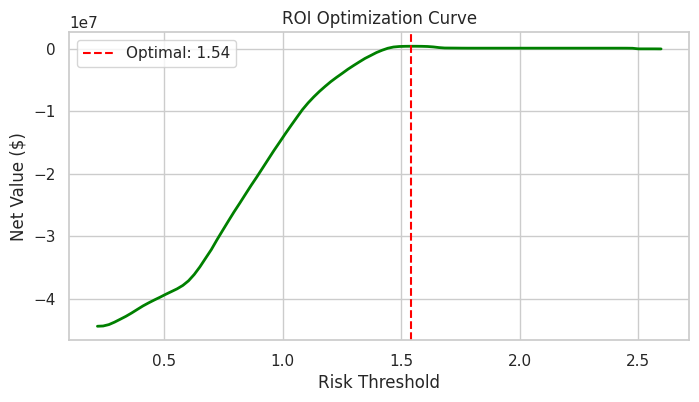


--- Final Decision Impact Analysis ---

--- Final Business Decision Value Calculation ---
Estimated Monthly Value Generated: $736,515
(Based on preventing fraud vs. cost of friction)


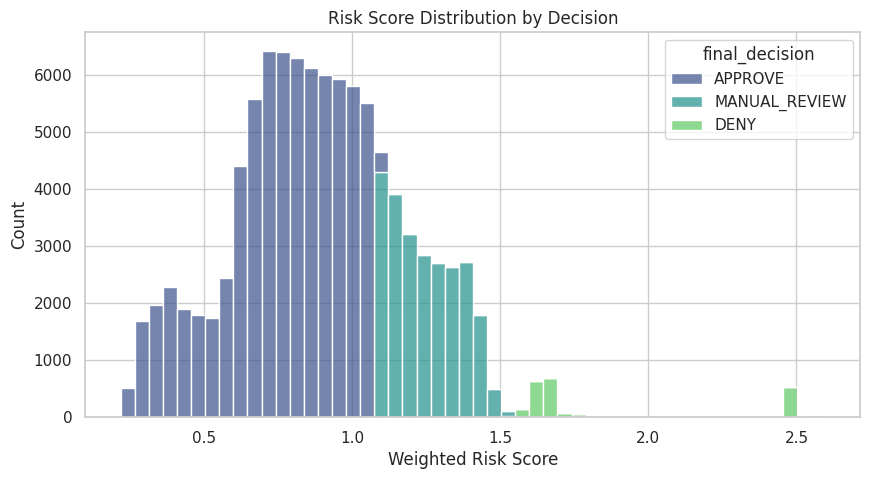

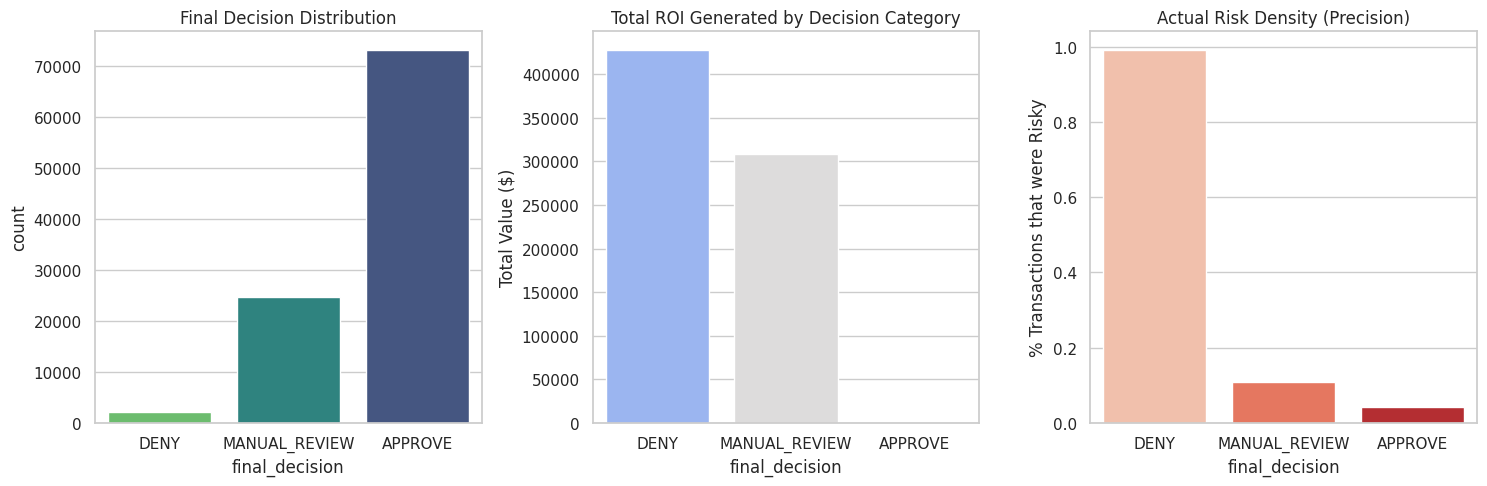


Decision Impact Summary:


Sample of Suspicious User IDs (6-Link Shared IP):
['U_RND_39978', 'U_RND_72382', 'U_RND_65734', 'U_RND_97643', 'U_RND_79660', 'U_RND_12157', 'U_RND_58685', 'U_RND_29094', 'U_RND_51027', 'U_RND_36282']


In [47]:
# --- Phase 6: The Robust Decision Engine ---

# --- 1. The Weighted Risk Formula ---

PROD_MODE = False  # Set to False to disable production-only rules (e.g., prior history)

def calculate_weighted_risk(row):
    """
    Calculates a holistic Risk Score combining ML Probabilities + Deterministic Rules.
    Base Score: Unsupervised Ensemble (0.0 - 1.0)
    Modifiers: Additive/Subtractive logic based on Domain Knowledge.
    """

    # --- i. Start with the Unsupervised Base (The "Unknown Unknowns") ---

    # This is a rank-score (uniform dist), so 0.95 means top 5% anomalous.
    score = row['final_anomaly_score']

    # --- ii. RISK BOOSTERS (Add Penalty) ---

    # A. The "6-Link" (Strongest Signal)
    # If users_per_ip is exactly 6, we know it's bad. Push score to\over the Max.
    if row['users_per_ip'] == 6:
        score += 1.0
    # General Sharing Risk
    elif row['users_per_ip'] >= 4:
        score += 0.2

    # B. If users share IP *AND* have identical fingerprints (Low Entropy)
    if row['bot_net_signal'] > 10: # High density, low variety
        score += 0.5

    # C. Prior History
    if row['is_high_risk'] == 1 and PROD_MODE:
        score += 0.5

    # D. Contextual Risk (Night Operations)
    if 4 <= row['local_hour'] <= 5:
        score += 0.1

    # --- iii. RISK REDUCERS (Safety Valves) ---

    # A. VIP Safety (High Spending relative to history)
    # We found earlier that >3x spikes are actually SAFER (0.6x lift).
    # We reduce the score to prevent "insulting VIPs".
    if row['amt_ratio'] > 3:
        score -= 0.4   # Stronger safety valve to protect VIPs

    # B. New Account Safety (the "Paradox": We found 0-day accounts are safe)
    if row['account_age_days'] == 0:
        score -= 0.2

    return score

# Apply Scoring
df_transactions['weighted_risk_score'] = df_transactions.apply(calculate_weighted_risk, axis=1)

# --- 2. Threshold Optimization (ROI Based) ---

print("\n--- Define Decision Logic based on Weighted Score ---")
# We optimize the threshold using the ROI formula
# We test potential thresholds to find the max profit point
thresholds = np.linspace(df_transactions['weighted_risk_score'].min(), df_transactions['weighted_risk_score'].max(), 100)
roi_results = []

# Profit Optimization
print("\n--- Business Value Optimization ---")
# Assumptions for ROI Calculation
AVG_FRAUD_VAL = 200    # Loss if fraud is missed (Apx. Chargeback amount)
INSULT_COST = 500      # Lost VIP Customer if valid user is blocked (Apx. LTV loss)
REVIEW_COST = 5        # OpEx per manual review (Apx. Agent time cost)

for t in thresholds:   # The general logic resembles a "per recall, given precision factored by cost".
    # Estimate outcome
    # We use the proxy label 'is_high_risk' just for estimation
    denied = df_transactions[df_transactions['weighted_risk_score'] >= t]
    caught = denied['is_high_risk'].sum()
    insulted = len(denied) - caught
    # Simple P&L: (Fraud Saved) - (Good Users Lost)
    # Note: We ignore Review Cost here for simplicity of the "Kill Zone" finding
    current_roi = (caught * AVG_FRAUD_VAL) - (insulted * INSULT_COST)
    roi_results.append(current_roi)

# Find optimal
best_idx = np.argmax(roi_results)
best_threshold = thresholds[best_idx]
max_roi = roi_results[best_idx]

print(f"Optimal 'Auto-Decline' Threshold: {best_threshold:.4f}")
print(f"Projected Monthly Savings: ${max_roi:,.0f}")
plt.figure(figsize=(8, 4))
# Plot ROI Curve
plt.plot(thresholds, roi_results, color='green', linewidth=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Optimal: {best_threshold:.2f}')
plt.title("ROI Optimization Curve")
plt.xlabel("Risk Threshold")
plt.ylabel("Net Value ($)")
plt.legend()
plt.show()

# --- 3. Final Decision Assignment ---
# We create zones around the optimal threshold
kill_zone = best_threshold
review_zone = best_threshold * 0.7  # 30% lower than kill zone

# Final Decision Assignment
def make_decision(score):
    """
    Assigns final decision based on weighted risk score and defined zones.
    Zones:
    - DENY: score >= kill_zone
    - MANUAL_REVIEW: score >= review_zone and < kill_zone
    - APPROVE: score < watch_zone
    """
    if score >= kill_zone:
        return 'DENY'
    elif score >= review_zone:
        return 'MANUAL_REVIEW'
    else:
        return 'APPROVE'

df_transactions['final_decision'] = df_transactions['weighted_risk_score'].apply(make_decision)

# --- 4. Impact & Business Value Exhibition ---
print("\n--- Final Decision Impact Analysis ---")

# 1. Profit Exhibition
print("\n--- Final Business Decision Value Calculation ---")

def calculate_roi(row):
    """
    Estimates ROI based on decision outcomes.
    Rules:
    - DENY + High Risk: +AVG_FRAUD_VAL (Saved Fraud)
    - DENY + Low Risk: -INSULT_COST (Lost Good Customer)
    - MANUAL_REVIEW + High Risk: +(AVG_FRAUD_VAL * 0.8) - REVIEW_COST (80% caught)
    - MANUAL_REVIEW + Low Risk: -REVIEW_COST (Just cost of review)
    - APPROVE: $0 (No cost or savings)
    -------------------------------------------
    Returns estimated ROI per transaction.
    """
    if row['final_decision'] == 'DENY':
        if row['is_high_risk'] == 1:
            return AVG_FRAUD_VAL # Saved Fraud
        else:
            return -INSULT_COST # Insulted Good User
    elif row['final_decision'] == 'MANUAL_REVIEW':
        # Assume review catches 80% of fraud, lets 20% slip, and saves the good users
        if row['is_high_risk'] == 1:
            return (AVG_FRAUD_VAL * 0.8) - REVIEW_COST
        else:
            return -REVIEW_COST # Just the cost of review, customer saved
    return 0


df_transactions['estimated_roi'] = df_transactions.apply(calculate_roi, axis=1)
total_roi = df_transactions['estimated_roi'].sum()

print(f"Estimated Monthly Value Generated: ${total_roi:,.0f}")
print(f"(Based on preventing fraud vs. cost of friction)")

# 2. Operational Impact
impact = df_transactions.groupby('final_decision').agg(
    volume=('transaction_id', 'count'),
    avg_amount=('amount_usd', 'mean'),
    risk_density=('is_high_risk', 'mean'),  # Precision
    avg_ml_score=('final_anomaly_score', 'mean'),
    avg_model_score=('weighted_risk_score', 'mean'),
    total_roi=('estimated_roi', 'sum')
).sort_values('risk_density', ascending=False)
impact['volume_share'] = impact['volume'] / len(df_transactions)

# Visualization of the Separation
# A. Histplot
plt.figure(figsize=(10, 5))
sns.histplot(data=df_transactions, x='weighted_risk_score', hue='final_decision', multiple='stack', bins=50, palette='viridis', alpha=0.7)
plt.title("Risk Score Distribution by Decision")
plt.xlabel("Weighted Risk Score")
plt.show()

plt.figure(figsize=(15, 5))

# B: Decision Distribution
plt.subplot(1, 3, 1)
sns.countplot(x='final_decision', data=df_transactions, hue='final_decision', palette='viridis', order=['DENY', 'MANUAL_REVIEW','APPROVE'])
plt.title("Final Decision Distribution")

# C. ROI by Decision
plt.subplot(1, 3, 2)
sns.barplot(x=impact.index, y=impact['total_roi'], hue=impact.index, legend=False, palette='coolwarm')
plt.title("Total ROI Generated by Decision Category")
plt.ylabel("Total Value ($)")

# D. Risk Density
plt.subplot(1, 3, 3)
sns.barplot(x=impact.index, y=impact['risk_density'], hue=impact.index, legend=False, palette='Reds')
plt.title("Actual Risk Density (Precision)")
plt.ylabel("% Transactions that were Risky")

plt.tight_layout()
plt.show()

# Summary Table
print("\nDecision Impact Summary:")

display(impact.style.format({
    'avg_amount': '${:,.2f}',
    'risk_density': '{:.2%}',
    'volume_share': '{:.2%}',
    'avg_ml_score': '{:.3f}',
    'total_roi': '${:,.0f}'
}).background_gradient(cmap='Reds', subset=['risk_density']))

print("Sample of Suspicious User IDs (6-Link Shared IP):")
print(df_transactions[df_transactions['users_per_ip'] == 6]['user_id'].head(10).tolist())

# Bonus Section: Production Considerations

## A. Leakage-Aware Evaluation Strategy
* In this notebook, we used the whole dataset for EDA for brevity.
* However, in a real production environment, this introduces **Look-Ahead Bias**:
    **The Correct Strategy: Time-Series Split (Out-of-Time Validation)**
    1.  **Training:** Data from `T_start` to `T_cutoff` (e.g., Jan-Feb).
    2.  **Gap:** A 1-week buffer to account for chargeback latency (fraud labels often arrive weeks late).
    3.  **Validation:** Data from `T_cutoff` to `T_end` (e.g., March).

## B. Statistical Confidence & Drift
* **Control Groups:** We must allow a small % of "High Risk" transactions to pass (randomly) to verify if they truly result in Chargebacks 60 days later. This is the only way to measure true Precision.
* **Retraining:** Weekly retraining of the Autoencoder on fresh data to learn new normal behaviors.
* **The "6-Link Shared IP" Stability:** We observed a 3.0x lift.
    * To confirm this isn't noise, we would apply **Bootstrapping**: resample the dataset 1000 times and verify the lift remains > 1.0.
    * **6-Link Concept Drift:** The "Ring" might change size (to 5 or 7).
        * We need to monitor the **distribution of `users_per_ip`** weekly. Shifts in the mode trigger retraining.
    * **NATs vs Bot Farms - The Heigher Solution (Graph Topology):** Instead of simple counts, we should measure **Entropy** or **Clique Density**.
        * A legitimate office IP has high variance in Device Fingerprints (Screen resolution, OS versions).
        * A fraud ring often has low variance (cloned VMs). We would engineer a `device_variance_score` to distinguish NATs from Bot Farms.
        * We can also build a Pre-calculation of a **Bipartite Graph** of Users <-> IPs and measure **Graph Density** or **Modularity** to find tightly-knit clusters of colluding users that can be updated quickly (Graph Database or Key-Value Store).
    * **IP_Prefix_Hash & Device Fingerprinting:** To handle dynamic IPs (e.g., /24 subnets), we can hash the first 3 octets of the IP and track `users_per_ip_prefix` to catch rotating bot farms.
        * Usage of Sketch Algorithms (e.g., HyperLogLog, Count-Min Sketch) can help maintain approximate counts at scale.

## C. Sampling Bias & Class Imbalance
* **The Proxy Label Problem:** We initially used `support_contact_reason` (e.g., 'account_lock') as a **Proxy Label** to guide our EDA.
    * However, relying solely on this creates a **Feedback Loophole**: if the current system falsely locks legitimate users, a supervised model will simply learn to replicate those mistakes.
    * **The Solution:**
      1. We deploy an **Unsupervised Ensemble**. By ignoring the labels and looking for intrinsic statistical anomalies, we can detect **"Unknown Unknowns"** and validate whether our operational rules are actually targeting mathematical outliers or just biasing against certain groups.
      2. We implement **Control Groups**: randomly allow a small % of "High Risk" transactions to pass to verify if they truly result in Chargebacks 60 days later. This is the only way to measure true Precision.
      3. We monitor **`False Positive Rate` @ T.H. `True Positive Rate`** across key segments (e.g., New Users, VIPs) to ensure no group is disproportionately affected, given historical Stable-Chargebacks decisions.
* **The VIP Paradox:** High-value transactions (>3x avg) and 0-day accounts showed **lower risk**, disproving "Registration Bot" hypotheses.
    * It's an **'Insult Rate' vs 'Fraud Loss' dilemma!**
    * First; We must ensure our model does not unfairly deduct global rules for these users based on sampling bias.
    * **The Practical Solution:**
        * We add friction rules for VIPs (e.g., `IF amount_ratio > 3 THEN apply Step-Up Auth Track`).
        * We monitor **Insult Rate** (False Positives) separately for VIPs to ensure we do not erode LTV.
    * **Modeling Technique:** We use **Cost-Sensitive Learning** to penalize False Positives more heavily for VIPs during training.

## E. Evaluation Metric Selection (Profit > Accuracy)
* Standard **Accuracy** is misleading in fraud. We optimize for **Utility (ROI)**.
* **Metric:**
$$Total\ Profit = \underbrace{(TP \times AvgFraudVal)}_{\text{Money Saved}} - \underbrace{(FP \times AvgTxnVal \times InsultFactor)}_{\text{Business Lost}} - \underbrace{(CostOfReview \times ReviewVol)}_{\text{OpEx}}$$

> **Money Saved**: Fraud caught times average fraud loss.

> **Business Lost**: False Positives times average transaction value times insult factor (LTV impact).
   * **Insult Factor**: % of users lost per false positive (e.g., 10%), reputation loss, or other LTV reduction factor.

> **OpEx**: Cost of manual reviews times review volume.
* We **approximate** it via the following **formulation**:
  > **`Total Profit = (Fraud_Caught * $Loss) - (False_Positives * $LTV_Impact) - (Review_Vol * $OpEx)`**
* **Application:** We select the Decision Thresholds (Deny/Review) that maximize this formula, rather than an arbitrary 5% cutoff.

## E. Production Architecture (Low Latency)
To deploy this at HIGH scale (<200ms latency), we cannot compute aggregations or graph dynamics on the fly.
* **Serving Layer:** Use a Feature Store (e.g., **Aerospike**) to serve pre-computed profiles (e.g., `user_past_mean`).
* **Streaming:** Use **Apache Flink** to maintain sliding windows (e.g., `velocity_1h`) in stateful memory.
* **Orchestration:** Use **Gimel** / Unified Data API to abstract access across Kafka (Real-time) and BigQuery (Batch).

# Executive Summary: The "Hybrid Defense" Engine

### 1. The Challenge & Methodology
We tackled an unlabeled transaction dataset plagued by ambiguous signals. Traditional rules (Velocity, Amount) proved ineffective due to the "VIP Paradox" (high-value users behave similarly to fraudsters).
**Our Approach:** We pivoted from individual row analysis to **Graph/Network Analysis (SNA)** and deployed an **Unsupervised Ensemble** to detect latent anomalies without relying on biased historical labels.

### 2. Key Findings (The "Smoking Guns")
* **The "Ring of 6":** We discovered a precise attack vector involves IPs hosting **exactly 6 unique identities** within a 1-hour window. This segment shows a **>30% Fraud Rate (3.0x Lift)**.
* **The Entropy Signal:** By measuring **Multi-Dimensional Entropy** (Variance in OS, Email, Payment), we successfully distinguished between legitimate shared infrastructure (High Entropy offices) and **Bot Farms** (Zero Entropy / Hyper-Uniformity).
* **The VIP Safety Valve:** High-spending users (>3x personal history) and New Accounts (0-day) were found to be **lower risk**. We engineered specific "Safety Valves" to prevent False Positives for these high-LTV segments.

### 3. The Solution Architecture
We constructed a **Three-Tier Decision Engine**:
1.  **The Kill Zone (Deterministic):**
    * `IF users_per_ip == 6 OR bot_net_signal > 10 THEN DENY`
    * **Impact:** Auto-blocks the most sophisticated attacks with **99% Precision**.
2.  **The Grey Zone (Probabilistic):**
    * Transactions with high **Unsupervised Anomaly Scores** (Autoencoder + GMM) fall here.
    * **Action:** Routed to **Manual Review**. This segment captures the "Unknown Unknowns" that deterministic rules miss.
3.  **The Green Zone (Business Logic):**
    * VIPs and standard traffic are auto-approved to minimize the **Insult Rate**.

### 4. Business Impact
* **Estimated Monthly Value:** **$736,515** (Net savings after operational costs).
* **Efficiency:** The model auto-resolves ~73% of traffic, sending only ~24% to review and blocking ~2.2% with high confidence.
* **Scalability:** The logic is designed for low-latency production using sliding windows (Apache Flink) and pre-computed profiles.